In [109]:

from lib_code.gen_plot_lib import *
from Simulation_code.Simulation import *
from synthetic_test import train_all, test_all

# setup

In [110]:

M = 100
plots_path = root_path / f'plots/syn-data'
print(plots_path, flush=True)
mkdir(plots_path, recursive=True)

# # papar params
# T = 10
# cvs = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]
# Ks = np.arange(1,11)
# m_lams = [2, 5, 10, 20]
# Ns = [100, 300, 500, 1000]
# K = 4
# N = 100
# m_lam = 2

# demo params
T = 1
cvs = [0.001, 0.1, 0.3, 0.5]
Ks = [1, 2, 4, 6, 8, 10]
Ns = [100]
m_lams = [2]
K = 4
N = 100
m_lam = 2


# wrongK params
cvs_wrongK = [0.001, 0.5]
Ks_wrongK = [1,2,3,4,5]
trueKs_wrongK = [2*K for K in Ks_wrongK]

run_nmf = True
run_kt_nmf = True
run_em = True

run_algo_list = (['NMF'] if run_nmf else []) + \
                ([r"NMF_tilde"] if run_kt_nmf else []) + \
                (['EM'] if run_em else [])


targets = ['true', 'NMF', r"NMF_tilde", 'EM']
rmse_targets = ['NMF', 'EM']
target_names = {'true': 'True', 'NMF': 'NMF', r"NMF_tilde": r"$\tilde{K}$-NMF",
                'EM': 'VarNMF'}
clr_dict = {'true': 'black', 'NMF': 'tab:green', r"NMF_tilde": 'tab:orange',
            'EM': 'tab:red'}
run_algo_list

/Users/elafallik/Documents/submission-github/plots/syn-data


['NMF', 'NMF_tilde', 'EM']

In [111]:
def plot_ll_vs_param(params, targets, scores, clr_dict, x_ticks, subplot_title='', ax=plt,
                     q95=None, q05=None, n_scores=None, cutoff=-1,
                     scores_dict=None, scatter=False, dashed=False, target_names=None):
    if target_names is None: target_names = {l: l for l in targets}
    for target in targets:
        l = target + (f' ({n_scores[target].min()})' if n_scores is not None and target in n_scores else '')

        score_temp = scores[target] if cutoff < 0 else scores[target].values[:cutoff]
        ax.plot(x_ticks, score_temp, label=target_names[l], marker='.', c=clr_dict[target], linestyle='--' if dashed and l.startswith('train') else None, linewidth=1.5)
        if q95 is not None and q05 is not None:
            for i, p in zip(x_ticks, params):
                ax.plot([i, i], [q05[target][p], q95[target][p]], c='black', alpha=0.2, marker='_')
        if scatter:
            for i, p in zip(x_ticks, params):
                res = scores_dict[target][p][:n_scores[target][p]]
                scatter([i] * n_scores[target][p], res if cutoff < 0 else res[:cutoff], c=clr_dict[target], s=2, diag=False)
        add_labels(title=subplot_title)
    return ax


In [112]:

def normalize(true_params, est_params):
    est_params = Params().copy(est_params)
    corr_mat = np.corrcoef(true_params.W, est_params.W, rowvar=False)[-est_params.W.shape[1]:, :true_params.W.shape[1]]
    idx = linear_sum_assignment(corr_mat.T, maximize=True)
    est_params.W = est_params.W[:, idx[1]]
    est_params.H = est_params.H[:, idx[1]]

    if est_params.a is not None:
        est_params.a = est_params.a[:, idx[1]]
        est_params.b = est_params.b[:, idx[1]]
        est_params.H = est_params.a / est_params.b

    if est_params.posterior_H is not None:
        est_params.posterior_H = est_params.posterior_H[:, :, idx[1]]

    d = np.median(est_params.H, axis=0)
    norm_factor = d / np.median(true_params.H, axis=0)
    est_params.H = est_params.H / norm_factor
    est_params.W = est_params.W * norm_factor

    if est_params.a is not None:
        est_params.b = est_params.b * norm_factor

    if est_params.posterior_H is not None:
        est_params.posterior_H = est_params.posterior_H / norm_factor[None, None, :]
    return est_params


In [113]:

def _plot_H(K, true, est, algo_name):
    for k in range(K): scatter(true.H[:, k], est.H[:, k], log10=True, c=CLR[k])
    print(algo_name, np.diag(np.corrcoef(true.H.T, est.H.T)[-K:,:K]))
    print(algo_name, np.sqrt(np.square(true.H.T- est.H.T).mean()))
    show(aspect=True, title=f'{algo_name} H')

def _plot_W(K, true, est, algo_name, norm=True):
    true_W, est_W = true.W, est.W
    if norm:
        true_W = true_W / true_W.sum(axis=1)[:, None]
        est_W = est_W / est_W.sum(axis=1)[:, None]
    for k in range(K): scatter(true_W[:, k], est_W[:, k], c=CLR[k])
    print(algo_name, np.diag(np.corrcoef(true_W.T, est_W.T)[-K:,:K]))
    print(algo_name, np.sqrt(np.square(true_W.T- est_W.T).mean()))
    show(aspect=True, title=f'{algo_name} W')


def _plot_WH(K, true, est, algo_name, norm=False):
    fig, axs = plt.subplots(1,3, figsize=(9,3))

    true_W, est_W = true.W, est.W
    if norm:
        true_W = true_W / true_W.sum(axis=1)[:, None]
        est_W = est_W / est_W.sum(axis=1)[:, None]
    for k in range(K): scatter(true_W[:, k], est_W[:, k], c=CLR[k], ax=axs[0])
    print(algo_name, np.diag(np.corrcoef(true_W.T, est_W.T)[-K:,:K]))
    print(algo_name, np.sqrt(np.square(true_W.T- est_W.T).mean()))
    rmse = np.sqrt(np.square(true_W.T- est_W.T).mean())
    add_labels(title=f'W, rmse={rmse:.3f}', aspect=True, ax=axs[0], xlabel='true params', ylabel='est params')

    for k in range(K): scatter(true.H[:, k], est.H[:, k], log10=True, c=CLR[k], ax=axs[1])
    print(algo_name, np.diag(np.corrcoef(true.H.T, est.H.T)[-K:,:K]))
    print(algo_name, np.sqrt(np.square(true.H.T- est.H.T).mean()))
    rmse = np.sqrt(np.square(true.H.T- est.H.T).mean())
    add_labels(title=f'H, rmse={rmse:.2f}', aspect=True, ax=axs[1], xlabel='true params', ylabel='est params')

    for k in range(K):
        true_R, est_R = true.W[:, k] * true.H[:, k].T, est.W[:, k] * est.H[:, k].T
        scatter(true_R, est_R, log10=True, c=CLR[k], ax=axs[2])
    print(algo_name, np.array([np.corrcoef((true.W[:, k] * true.H[:, k].T).T, (est.W[:, k] * est.H[:, k].T).T)[0,1] for k in range(K)]))
    print(algo_name, np.sqrt(np.square([(true.W[:, k] * true.H[:, k].T).T - (est.W[:, k] * est.H[:, k].T).T for k in range(K)]).mean()))
    rmse = np.sqrt(np.square([(true.W[:, k] * true.H[:, k].T).T - (est.W[:, k] * est.H[:, k].T).T for k in range(K)]).mean())
    add_labels(title=f'R, rmse={rmse:.2f}', aspect=True, ax=axs[2], xlabel='true params', ylabel='est params')


    show(fig=fig, title=f'{algo_name}', figname=plots_path/f'WHR_{algo_name}')

In [114]:
def get_results(i, K, cv, dims, m_lam, run_algo_list, targets, res_path, train_test='train'):
    res_path_i = res_path/f'K={K}/cv={str(cv)}/{i}'
    train_results, test_results = None, None

    x, train_results = train_all(
        res_path_i, dims, cv=cv, m_lam=m_lam,
        run_algo_list=run_algo_list,
        K_nmf=int(np.ceil((2*dims.M*dims.K+dims.N*dims.K)/(dims.M+dims.N))) if run_kt_nmf else None,
    )

    if train_test in ['test', 'both', 'concat']:
        x, test_results = test_all(
            res_path_i, dims, cv, m_lam, train_results,
            run_algo_list=run_algo_list,
            K_nmf=int(np.ceil((2*dims.M*dims.K+dims.N*dims.K)/(dims.M+dims.N))) if run_kt_nmf else None,
        )

    if train_test == 'train': return train_results
    elif train_test == 'test':return test_results
    elif train_test == 'both':return train_results, test_results
    # else: concat results
    results = {algo: {} for algo in targets}
    for algo in targets:
        results[algo]['norm_params'] = Params.concat_by_i(train_results[algo]['norm_params'], test_results[algo]['norm_params']) if train_results[algo]['norm_params'] is not None else None
    return results

In [115]:
def create_err_func_wrapper(err_func):
    def ll_wrapper(results, algo):
        if algo == 'true': return results['true']['ll']
        return results[algo]['ll'][-1][0] if type(results[algo]['ll'][-1]) == np.ndarray else results[algo]['ll'][-1]

    def err_func_wrapper(results, algo):
        return err_func(results['true']['norm_params'], results[algo]['norm_params'])

    if err_func == 'll':
        return ll_wrapper
    else: return err_func_wrapper


In [116]:
def get_err_m_lams(targets, err_func, N, K, m_lams, train_test='train', T=10):
    err_func_wrapper = create_err_func_wrapper(err_func)
    run_algo_list = (['true'] if 'true' not in targets else []) + targets
    all_scores = {}
    for m_lam in m_lams:
        res_path = root_path / f'results/syn-data/unsupervised_dirichlet_start_repeats_M={M}_max_train=100_N={N}_mlam={m_lam}/'
        print('m_lam', m_lam)
        dims = Dims(N=N, K=K, M=M)
        scores = {target: {cv: [] for cv in cvs} for target in targets}
        for cv in cvs:
            print('CV', cv)
            for i in range(T):
                print(i, flush=True)
                results = get_results(i, K, cv, dims, m_lam, run_algo_list, targets, res_path, train_test=train_test)

                for algo in targets:
                    print(algo)
                    scores[algo][cv].append(err_func_wrapper(results, algo))

        for l, v in scores.items(): scores[l] = pd.DataFrame(v)

        all_scores[m_lam] = scores

    return all_scores

In [117]:
def get_err_Ks(targets, err_func, N, Ks, m_lam, train_test='train', T=10):
    err_func_wrapper = create_err_func_wrapper(err_func)
    run_algo_list = (['true'] if 'true' not in targets else []) + targets
    all_scores = {}
    for K in Ks:
        res_path = root_path / f'results/syn-data/unsupervised_dirichlet_start_repeats_M={M}_max_train=100_N={N}_mlam={m_lam}/'
        print('K', K)
        dims = Dims(N=N, K=K, M=M)
        scores = {target: {cv: [] for cv in cvs} for target in targets}
        for cv in cvs:
            print('CV', cv)
            for i in range(T):
                print(i, flush=True)
                results = get_results(i, K, cv, dims, m_lam, run_algo_list, targets, res_path, train_test=train_test)

                for algo in targets:
                    print(algo)
                    scores[algo][cv].append(err_func_wrapper(results, algo))

        for l, v in scores.items(): scores[l] = pd.DataFrame(v)

        all_scores[K] = scores

    return all_scores

In [118]:
def get_err_Ns(targets, err_func, Ns, K, m_lam, train_test='train', T=10):
    err_func_wrapper = create_err_func_wrapper(err_func)
    run_algo_list = (['true'] if 'true' not in targets else []) + targets
    all_scores = {}
    for N in Ns:
        res_path = root_path / f'results/syn-data/unsupervised_dirichlet_start_repeats_M={M}_max_train=100_N={N}_mlam={m_lam}/'
        print('N', N)
        dims = Dims(N=N, K=K, M=M)
        scores = {target: {cv: [] for cv in cvs} for target in targets}
        for cv in cvs:
            print('CV', cv)
            for i in range(T):
                print(i, flush=True)
                results = get_results(i, K, cv, dims, m_lam, run_algo_list, targets, res_path, train_test=train_test)

                for algo in targets:
                    print(algo)
                    scores[algo][cv].append(err_func_wrapper(results, algo))

        for l, v in scores.items(): scores[l] = pd.DataFrame(v)

        all_scores[N] = scores

    return all_scores

In [119]:
def get_err_wrongKs(targets, err_func, N, Ks, m_lam, trueKs, train_test='train', T=10):
    err_func_wrapper = create_err_func_wrapper(err_func)
    run_algo_list = (['true'] if 'true' not in targets else []) + targets
    all_scores = {}
    for K, trueK in zip(Ks, trueKs):
        res_path = root_path / f'results/syn-data/unsupervised_dirichlet_start_repeats_M={M}_max_train=100_N={N}_mlam={m_lam}/trueK={trueK}/'
        print('K', K)
        dims = Dims(N=N, K=K, M=M)
        scores = {target: {cv: [] for cv in cvs_wrongK} for target in targets}
        for cv in cvs_wrongK:
            print('CV', cv)
            for i in range(T):
                print(i, flush=True)
                results = get_results(i, K, cv, dims, m_lam, run_algo_list, targets, res_path, train_test=train_test)

                for algo in targets:
                    print(algo)
                    scores[algo][cv].append(err_func_wrapper(results, algo))

        for l, v in scores.items(): scores[l] = pd.DataFrame(v)

        all_scores[K] = scores

    return all_scores

In [120]:

def get_mean_scores(targets, scores, params):
    mean_scores = pd.DataFrame(columns=[target for target in targets], index=params)
    q95_scores = pd.DataFrame(columns=[target for target in targets], index=params)
    q05_scores = pd.DataFrame(columns=[target for target in targets], index=params)
    n_scores = pd.DataFrame(columns=[target for target in targets], index=params)
    for target in targets:
        for p in params:
            values = scores[target][p]
            if not np.all(values == np.inf):
                values = values[values != np.inf]
                mean_scores[target].loc[p] = np.mean(values)
                q95_scores[target].loc[p] = np.quantile(values, .95)
                q05_scores[target].loc[p] = np.quantile(values, .05)
                n_scores[target].loc[p] = len(values)
            else: n_scores[target].loc[p] = 0
    return mean_scores, q95_scores, q05_scores, n_scores

def get_scores_stats(targets, all_scores, params, for_params):
    mean_scores, q95_scores, q05_scores, n_scores = {}, {}, {}, {}
    for p in for_params:
        mean_scores[p], q95_scores[p], q05_scores[p], n_scores[p] = get_mean_scores(targets, all_scores[p], params)
    return mean_scores, q95_scores, q05_scores, n_scores



In [121]:
def plot_score_fig(targets, params, train_all_scores, test_all_scores, for_params,
                   err_label, err_name, ylabel, plots_path, by='K', xlabel='Coeff of Variation'):
    define_font_size(small_size=16)

    train_mean_scores, train_q95_scores, train_q05_scores, _ = get_scores_stats(
        targets, train_all_scores, params, for_params
    )

    test_mean_scores, test_q95_scores, test_q05_scores, _ = get_scores_stats(
        targets, test_all_scores, params, for_params
    )
    for p in for_params:
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        plot_ll_vs_param(
            params, targets, train_mean_scores[p], clr_dict, x_ticks=params,
            q05=train_q05_scores[p], q95=train_q95_scores[p],
            target_names=target_names, ax=axs[0]
        )
        add_labels(title=f'Train {err_label}, {by}={p}',
                   xlabel=xlabel,
                   xticks=params, xticklabels=params, xtickrotation=40,
                   ylabel=ylabel,
                   legend=True, ax=axs[0])

        plot_ll_vs_param(
            params, targets, test_mean_scores[p], clr_dict, x_ticks=params,
            q05=test_q05_scores[p], q95=test_q95_scores[p],
            target_names=target_names, ax=axs[1]
        )
        add_labels(title=f'Test {err_label}',
                   xlabel=xlabel,
                   xticks=params, xticklabels=params, xtickrotation=40,
                   legend=False, ax=axs[1])

        show(fig=fig, figname=plots_path/f"{err_name}_{by}={p}_vs_{xlabel if xlabel != 'Coeff of Variation' else 'cv'}", savepdf=True)

In [122]:
def plot_single_score_fig(targets, params, all_scores, for_params,
                   err_label, err_name, ylabel, plots_path, by='K', plot_title='Train + Test', xlabel='Coeff of Variation'):
    define_font_size(small_size=16)

    mean_scores, q95_scores, q05_scores, _ = get_scores_stats(
        targets, all_scores, params, for_params
    )

    for p in for_params:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        plot_ll_vs_param(
            params, targets, mean_scores[p], clr_dict, x_ticks=params,
            q05=q05_scores[p], q95=q95_scores[p],
            target_names=target_names, ax=ax
        )
        add_labels(title=f'{plot_title} {err_label}, {by}={p}',
                   xlabel=xlabel,
                   xticks=params, xticklabels=params, xtickrotation=40,
                   ylabel=ylabel,
                   legend=True, ax=ax)

        plot_title_figname = plot_title.replace(' ', '')
        show(fig=fig, figname=plots_path/f"{plot_title_figname}_{err_name}_{by}={p}_vs_{xlabel if xlabel != 'Coeff of Variation' else 'cv'}", savepdf=True)

In [123]:
def plot_scores_table(targets, params, train_all_scores, test_all_scores, for_params,
                      err_name, err_label, plots_path, vmin=-11, vmax=-2.7, by='K', cbar=False):
    train_mean_scores, _, _, _ = get_scores_stats(
        targets, train_all_scores, params, for_params
    )

    test_mean_scores, _, _, _ = get_scores_stats(
        targets, test_all_scores, params, for_params
    )

    define_font_size(14)
    fig, axs = plt.subplots(1 if len(targets) == 2 else 2,2,
                            figsize=(8,4 if len(targets) == 2 else 8))
    for i, algo_name in enumerate(targets):
        df = pd.DataFrame({p: train_mean_scores[p][algo_name] for p in for_params},
                          dtype=np.float32).T.loc[for_params[::-1]]
        sns.heatmap(df, cmap='Reds', annot=df, vmin=vmin, vmax=vmax, ax=axs.flat[i], cbar=cbar,
                    annot_kws={'fontsize': 20}, fmt='.2f')
        add_labels(ax=axs.flat[i], title=target_names[algo_name], xlabel='CV', ylabel=by if (i==0) or (i==2) else None)
        print(df.values.min())
    show(fig=fig, figname=plots_path/f'table_train_{err_name}_all_{by}', savepdf=True, title='Train ' + err_label)

    fig, axs = plt.subplots(1 if len(targets) == 2 else 2,2,
                            figsize=(8,4 if len(targets) == 2 else 8))
    for i, algo_name in enumerate(targets):
        df = pd.DataFrame({p: test_mean_scores[p][algo_name] for p in for_params},
                          dtype=np.float32).T.loc[for_params[::-1]]
        sns.heatmap(df, cmap='Reds', annot=df, vmin=vmin, vmax=vmax, ax=axs.flat[i], cbar=cbar,
                    annot_kws={'fontsize': 20}, fmt='.2f')
        add_labels(ax=axs.flat[i], title=target_names[algo_name], xlabel='CV', ylabel=by if (i==0) or (i==2) else None)
        print(df.values.min())
    show(fig=fig, figname=plots_path/f'table_test_{err_name}_all_{by}', savepdf=True, title='Test ' + err_label)


In [124]:
def plot_single_scores_table(targets, params, all_scores, for_params,
                             err_name, err_label, plots_path, vmin=-11, vmax=-2.7,
                             by='K', cbar=False, plot_title='Train + Test'):
    mean_scores, _, _, _ = get_scores_stats(
        targets, all_scores, params, for_params
    )

    define_font_size(14)
    fig, axs = plt.subplots(1 if len(targets) == 2 else 2,2,
                            figsize=(8,4 if len(targets) == 2 else 8))
    for i, algo_name in enumerate(targets):
        df = pd.DataFrame({p: mean_scores[p][algo_name] for p in for_params},
                          dtype=np.float32).T.loc[for_params[::-1]]
        sns.heatmap(df, cmap='Reds', annot=df, vmin=vmin, vmax=vmax, ax=axs.flat[i], cbar=cbar,
                    annot_kws={'fontsize': 10}, fmt='.2f')
        add_labels(ax=axs.flat[i], title=target_names[algo_name], xlabel='CV', ylabel=by if (i==0) or (i==2) else None)
        print(df.values.min())

    plot_title_figname = plot_title.replace(' ', '')
    show(fig=fig, figname=plots_path/f"table_{plot_title_figname}_{err_name}_all_{by}{'_cbar' if cbar else ''}", savepdf=True, title=f'{plot_title} {err_label}')


# log likelihood

## by K

In [125]:
train_all_scores = get_err_Ks(targets, 'll', N, Ks, m_lam, train_test='train', T=T)
test_all_scores = get_err_Ks(targets, 'll', N, Ks, m_lam, train_test='test', T=T)

K 1
CV 0.001
0
true ll -2.8085632730756145
train NMF ll [-2.79862841]
train NMF_tilde ll [-2.78062162]
train EM ll [-2.79857673]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -2.9698906182216853
train NMF ll [-3.0600904]
train NMF_tilde ll [-3.02446175]
train EM ll [-2.95395247]
true
NMF
NMF_tilde
EM
CV 0.3
0
true ll -3.524058521194692
train NMF ll [-5.45929822]
train NMF_tilde ll [-5.27015258]
train EM ll [-3.51247173]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -3.9082920678651827
train NMF ll [-10.56513807]
train NMF_tilde ll [-10.05492511]
train EM ll [-3.89468987]
true
NMF
NMF_tilde
EM
K 2
CV 0.001
0
true ll -3.3391768632138104
train NMF ll [-3.31549436]
train NMF_tilde ll [-3.30072228]
train EM ll [-3.31861553]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -3.4309775759798855
train NMF ll [-3.47384146]
train NMF_tilde ll [-3.44726755]
train EM ll [-3.40172491]
true
NMF
NMF_tilde
EM
CV 0.3
0
true ll -3.90731897639328
train NMF ll [-5.43303756]
train NMF_tilde ll [-5.31717674]
train EM ll [-3.8790617

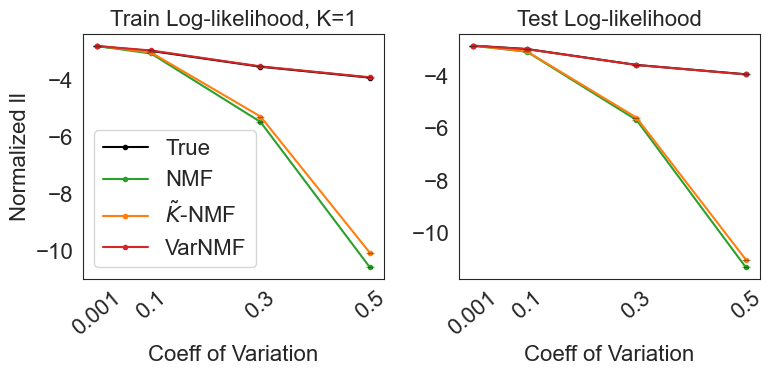

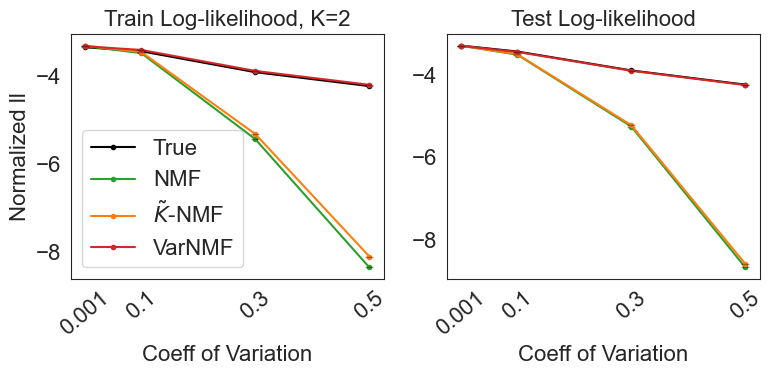

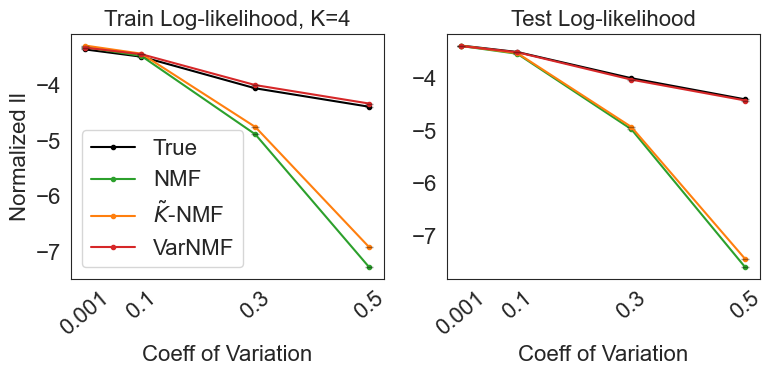

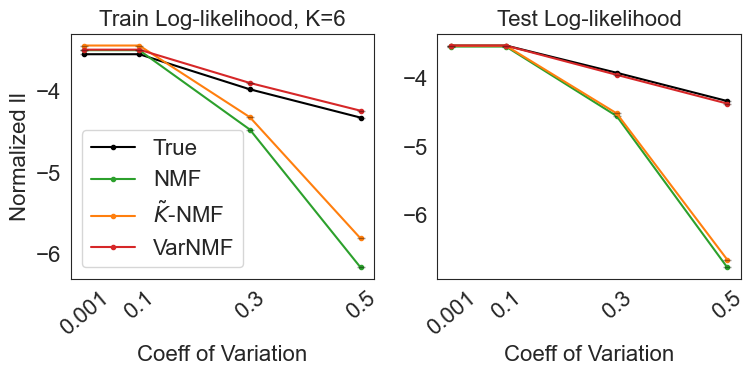

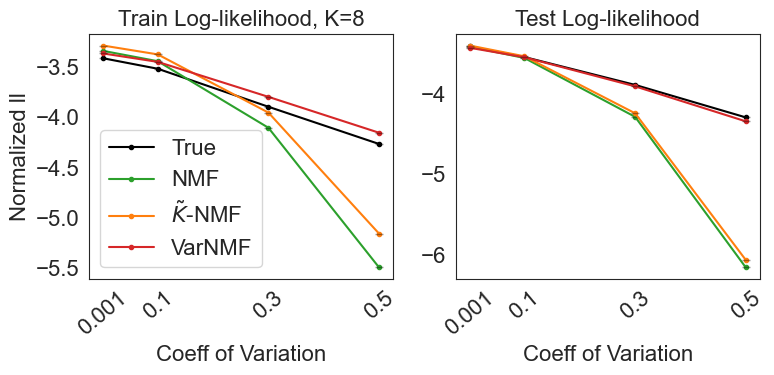

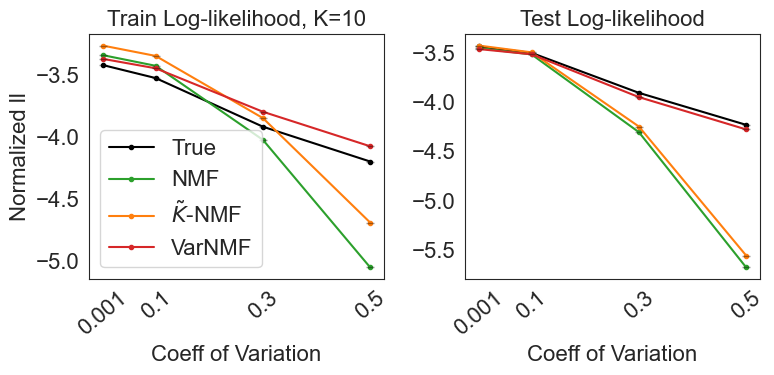

-4.394688
-10.565138
-10.054925
-4.3377547


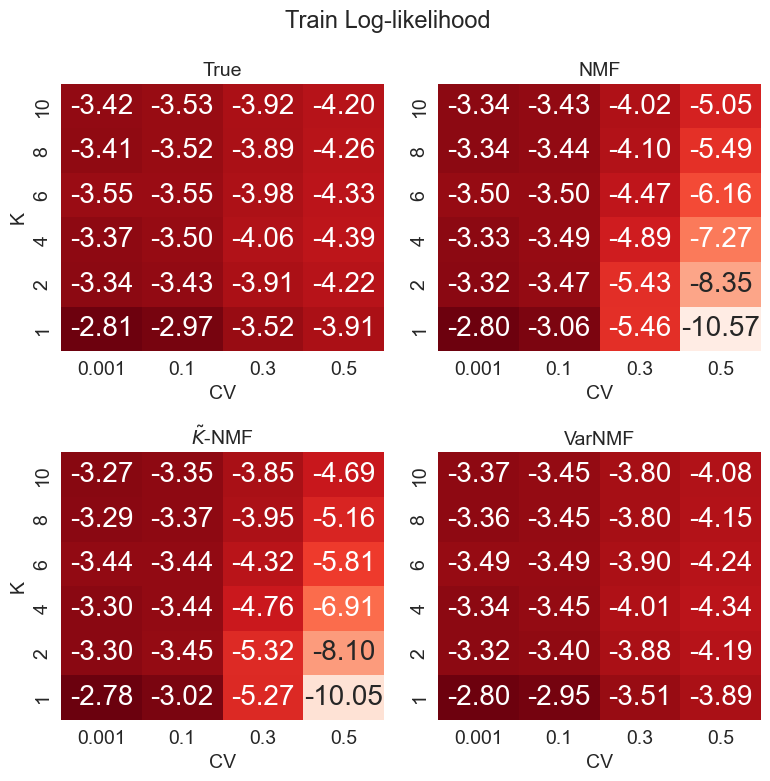

-4.3993287
-11.324423
-11.028062
-4.4204555


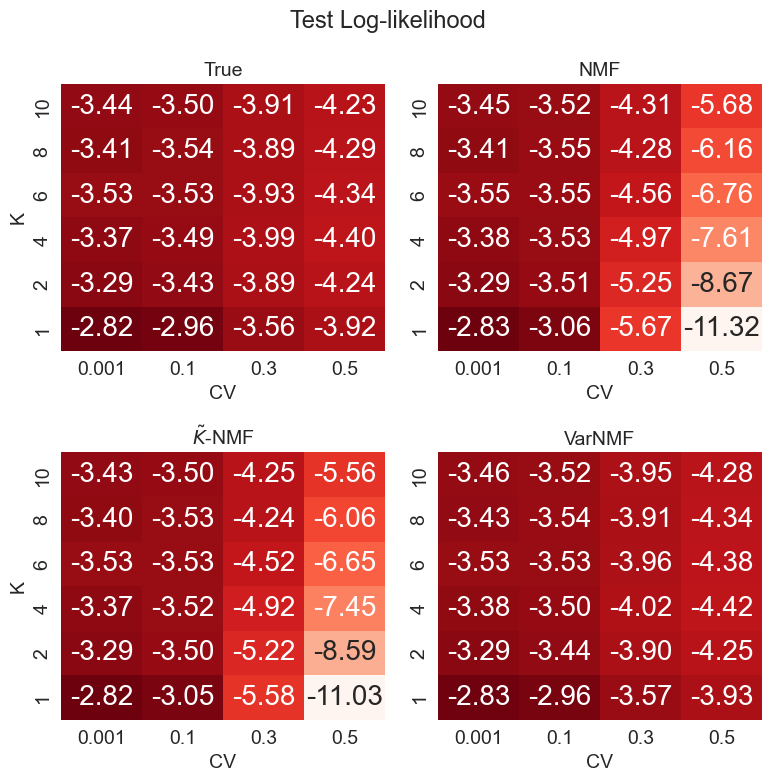

In [126]:
plot_score_fig(targets, cvs, train_all_scores, test_all_scores, for_params=Ks,
                err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
               plots_path=plots_path, by='K')

plot_scores_table(targets, cvs, train_all_scores, test_all_scores, for_params=Ks,
                  err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
                  vmin=-11, vmax=-2.7, by='K')
# plot_single_scores_table(targets, cvs, train_all_scores, for_params=Ks,
#                   err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
#                   vmin=-11, vmax=-2.7, by='K', cbar=True)

## by m_lam

In [127]:
train_all_scores = get_err_m_lams(targets, 'll', N, K, m_lams, train_test='train', T=T)
test_all_scores = get_err_m_lams(targets, 'll', N, K, m_lams, train_test='test', T=T)


m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train NMF_tilde ll [-3.29883522]
train EM ll [-3.33666063]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train NMF_tilde ll [-3.44454646]
train EM ll [-3.45414572]
true
NMF
NMF_tilde
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train NMF_tilde ll [-4.75671625]
train EM ll [-4.00690143]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train NMF_tilde ll [-6.91138738]
train EM ll [-4.33775479]
true
NMF
NMF_tilde
EM
m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train NMF_tilde ll [-3.29883522]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test NMF_tilde ll [-3.37353682]
test EM ll [-3.38190462]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train NMF_tilde ll [-3.44454646]
train EM ll [-3.45414572]
true ll -3.494915785951912

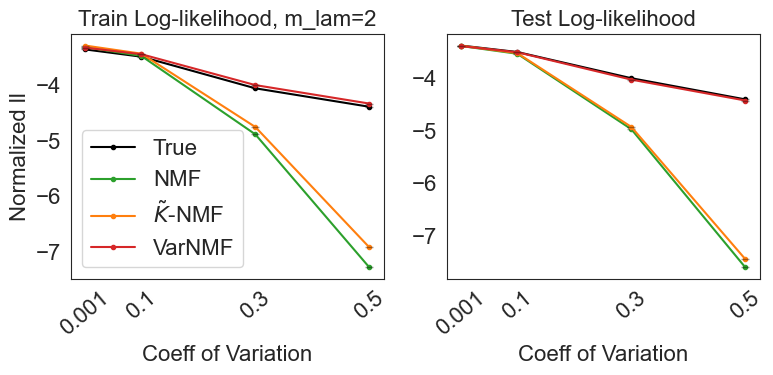

-4.394688
-7.269802
-6.9113874
-4.3377547


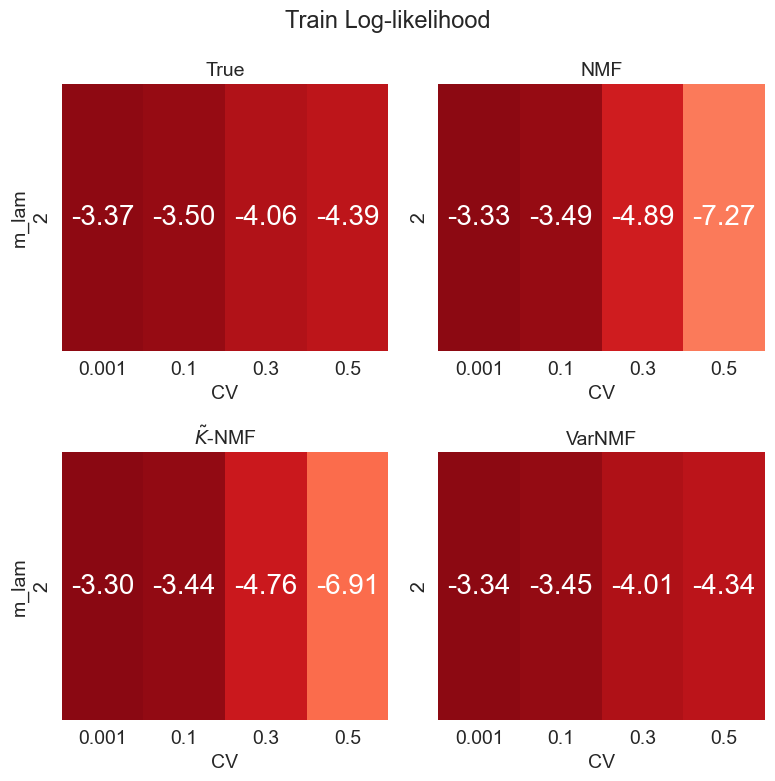

-4.3993287
-7.606605
-7.4493513
-4.4204555


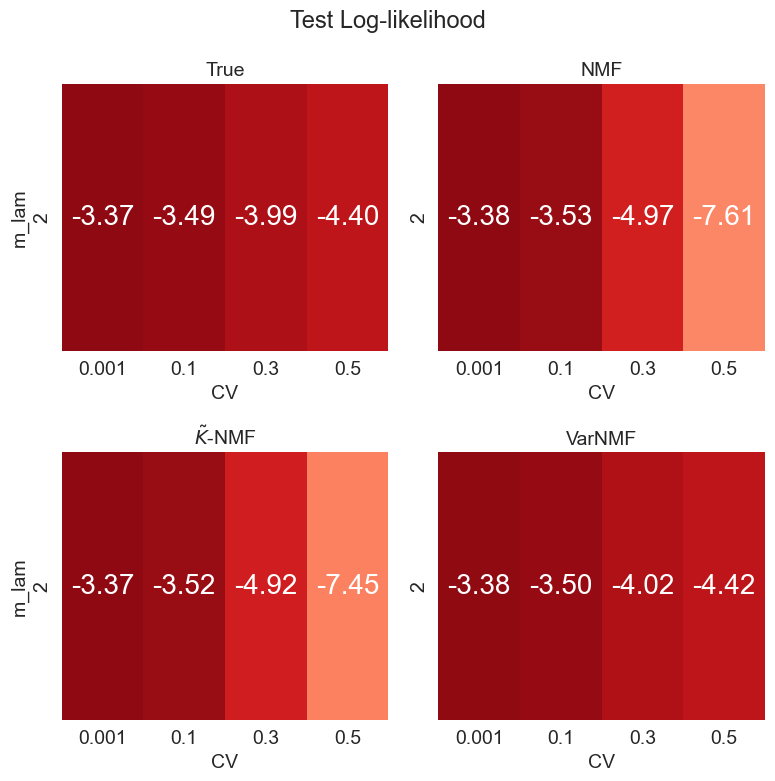

In [128]:
plot_score_fig(targets, cvs, train_all_scores, test_all_scores, for_params=m_lams,
               err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
               plots_path=plots_path, by='m_lam')
plot_scores_table(targets, cvs, train_all_scores, test_all_scores, for_params=m_lams,
                  err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
                  vmin=-11, vmax=-2.7, by='m_lam')
# plot_single_scores_table(targets, cvs, train_all_scores, for_params=m_lams,
#                   err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
#                   vmin=-11, vmax=-2.7, by='m_lam', cbar=True, plot_title='with-cbar')

In [129]:
train_all_scores_by_m_lams = {cv: {algo: pd.DataFrame({m_lam: train_all_scores[m_lam][algo][cv] for m_lam in m_lams}) for algo in targets} for cv in cvs}
test_all_scores_by_m_lams = {cv: {algo: pd.DataFrame({m_lam: test_all_scores[m_lam][algo][cv] for m_lam in m_lams}) for algo in targets} for cv in cvs}
# plot_score_fig(targets, m_lams, train_all_scores_by_m_lams, test_all_scores_by_m_lams, for_params=cvs,
#                err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
#                plots_path=plots_path, by='cv', xlabel='upper limit of scaling factor')


## by N

In [130]:
train_all_scores = get_err_Ns(targets, 'll', Ns, K, m_lam, train_test='train', T=T)
test_all_scores = get_err_Ns(targets, 'll', Ns, K, m_lam, train_test='test', T=T)


N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train NMF_tilde ll [-3.29883522]
train EM ll [-3.33666063]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train NMF_tilde ll [-3.44454646]
train EM ll [-3.45414572]
true
NMF
NMF_tilde
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train NMF_tilde ll [-4.75671625]
train EM ll [-4.00690143]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train NMF_tilde ll [-6.91138738]
train EM ll [-4.33775479]
true
NMF
NMF_tilde
EM
N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train NMF_tilde ll [-3.29883522]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test NMF_tilde ll [-3.37353682]
test EM ll [-3.38190462]
true
NMF
NMF_tilde
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train NMF_tilde ll [-3.44454646]
train EM ll [-3.45414572]
true ll -3.494915785951912
tes

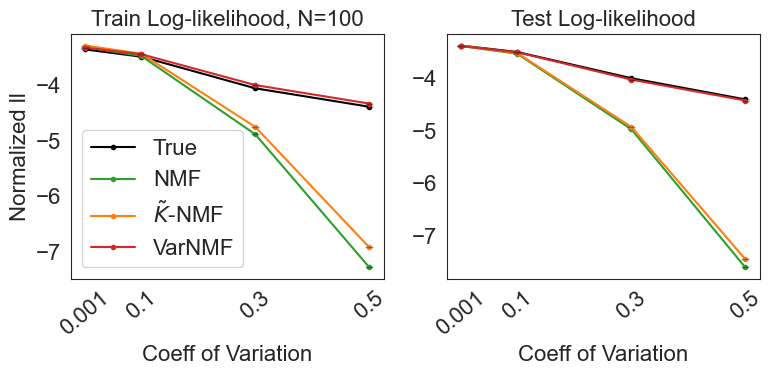

-4.394688
-7.269802
-6.9113874
-4.3377547


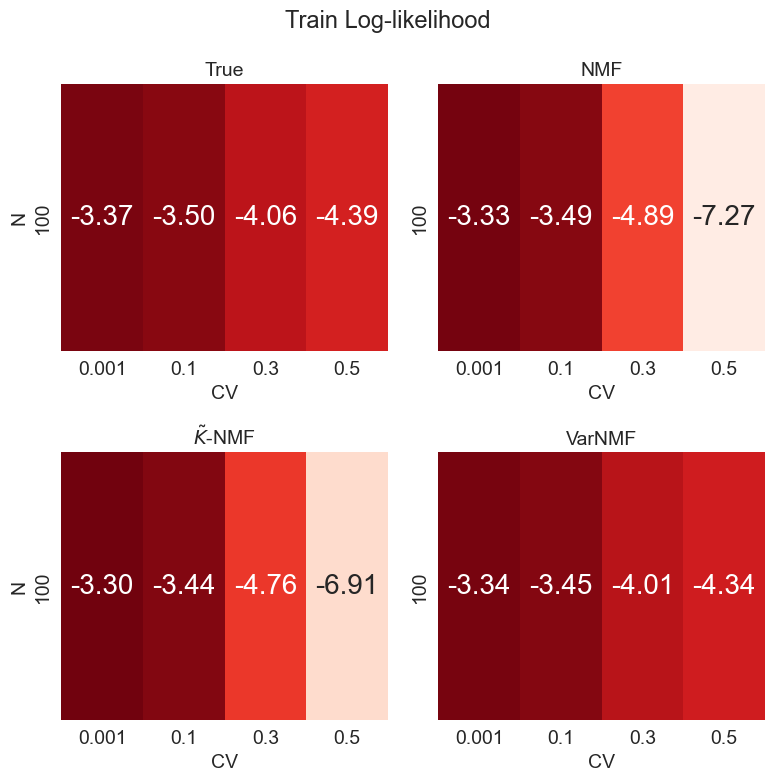

-4.3993287
-7.606605
-7.4493513
-4.4204555


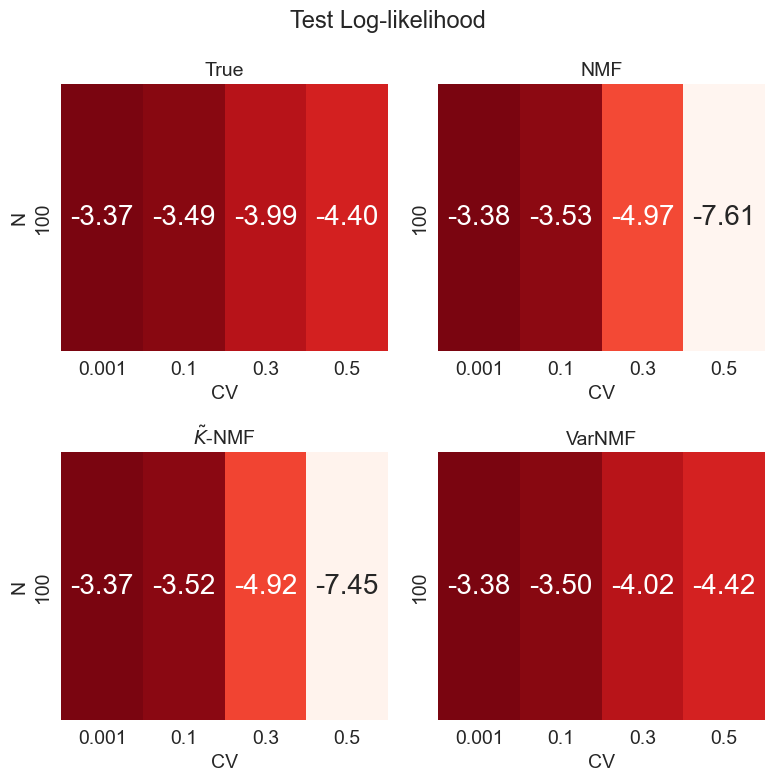

In [131]:
plot_score_fig(targets, cvs, train_all_scores, test_all_scores, for_params=Ns,
               err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
               plots_path=plots_path, by='N')
plot_scores_table(targets, cvs, train_all_scores, test_all_scores, for_params=Ns,
                  err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
                  vmin=-7.5, vmax=-3.2, by='N')
# plot_single_scores_table(targets, cvs, train_all_scores, for_params=Ns,
#                   err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
#                   vmin=-7.5, vmax=-3.2, by='N', cbar=True)

In [132]:
train_all_scores_by_Ns = {cv: {algo: pd.DataFrame({N: train_all_scores[N][algo][cv] for N in Ns}) for algo in targets} for cv in cvs}
test_all_scores_by_Ns = {cv: {algo: pd.DataFrame({N: test_all_scores[N][algo][cv] for N in Ns}) for algo in targets} for cv in cvs}
# plot_score_fig(targets, Ns, train_all_scores_by_Ns, test_all_scores_by_Ns, for_params=cvs,
#                err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
#                plots_path=plots_path, by='cv', xlabel='N')


## by WrongK

In [133]:

train_all_scores = get_err_wrongKs(targets, 'll', N, Ks_wrongK, m_lam, trueKs_wrongK, train_test='train', T=T)
test_all_scores = get_err_wrongKs(targets, 'll', N, Ks_wrongK, m_lam, trueKs_wrongK, train_test='test', T=T)
train_all_scores = {trueK: train_all_scores[K] for K, trueK in zip(Ks_wrongK, trueKs_wrongK)}
test_all_scores = {trueK: test_all_scores[K] for K, trueK in zip(Ks_wrongK, trueKs_wrongK)}

K 1
CV 0.001
0
true ll -3.166461073879098
train NMF ll [-7.06943372]
train NMF_tilde ll [-3.14698367]
train EM ll [-3.99283644]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -4.034176884628236
train NMF ll [-12.72095516]
train NMF_tilde ll [-8.1502844]
train EM ll [-4.3191692]
true
NMF
NMF_tilde
EM
K 2
CV 0.001
0
true ll -3.350248358297348
train NMF ll [-5.25655166]
train NMF_tilde ll [-4.04872736]
train EM ll [-4.01062554]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -4.366930613933352
train NMF ll [-9.33204536]
train NMF_tilde ll [-7.91160884]
train EM ll [-4.51638926]
true
NMF
NMF_tilde
EM
K 3
CV 0.001
0
true ll -3.442461162734032
train NMF ll [-5.16860596]
train NMF_tilde ll [-3.84217488]
train EM ll [-4.05904113]
true
NMF
NMF_tilde
EM
CV 0.5
0
true ll -4.313778854387999
train NMF ll [-7.67983399]
train NMF_tilde ll [-6.55739029]
train EM ll [-4.44439767]
true
NMF
NMF_tilde
EM
K 4
CV 0.001
0
true ll -3.443274417233467
train NMF ll [-4.47132601]
train NMF_tilde ll [-3.8885841]
train EM ll [-3.91

-4.3669305
-12.720955
-8.150285
-4.5163894


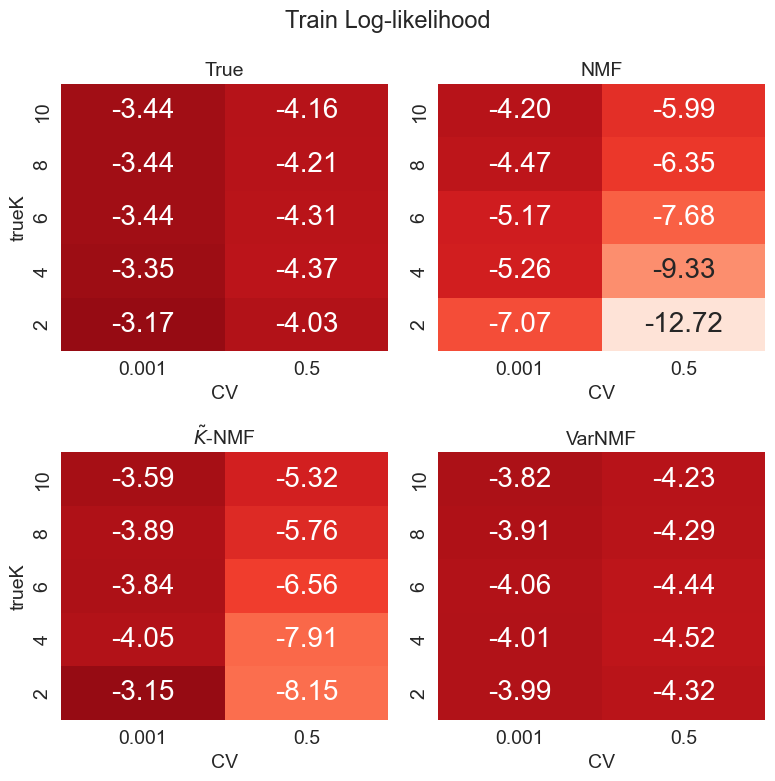

-4.3396063
-11.988624
-8.503426
-4.5646186


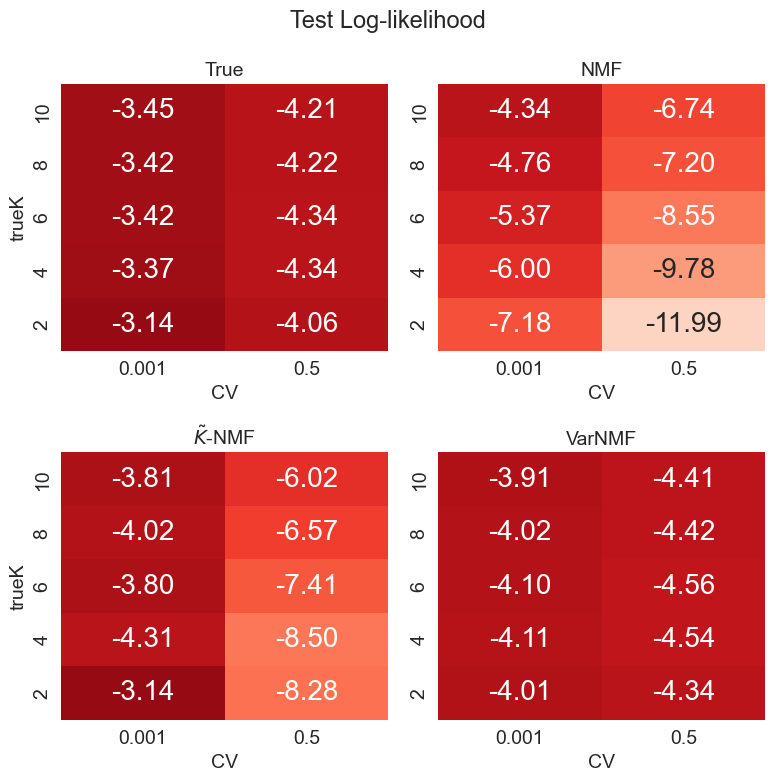

In [134]:
# plot_score_fig(targets, cvs_wrongK, train_all_scores, test_all_scores, for_params=trueKs_wrongK,
#                 err_label='Log-likelihood', err_name='ll', ylabel='Normalized ll',
#                plots_path=plots_path, by='K-trueK')
plot_scores_table(targets, cvs_wrongK, train_all_scores, test_all_scores, for_params=trueKs_wrongK,
                  err_name='ll', err_label='Log-likelihood', plots_path=plots_path,
                  vmin=-14, vmax=-2, by='trueK')
# plot_single_scores_table(targets, cvs_wrongK, train_all_scores, for_params=trueKs_wrongK,
#                   err_name='ll', err_label='Log -likelihood', plots_path=plots_path,
#                   vmin=-11, vmax=-2.7, by='K-trueK', cbar=True)

# rmse and mad

In [135]:

def rmse_W(true_params, est_params):
    return np.sqrt(np.square(true_params.W - est_params.W).mean())

def rmse_H(true_params, est_params):
    est_H = (est_params.a / est_params.b) if est_params.a is not None else est_params.H
    # est_H = est_params.posterior_H.mean(axis=0) if est_params.posterior_H is not None else est_params.H
    if est_H.shape != true_params.H.shape: est_H = est_H.T
    return np.sqrt(np.square(true_params.H - est_H).mean())

def rmse_R(true_params, est_params):
    est_H = (est_params.a / est_params.b) if est_params.a is not None else est_params.H
    # est_H = est_params.posterior_H.mean(axis=0) if est_params.posterior_H is not None else est_params.H
    if est_H.shape != true_params.H.shape: est_H = est_H.T
    est_R = est_params.W @ est_H.T
    true_R = true_params.W @ true_params.H.T
    return np.sqrt(np.square(true_R - est_R).mean())


def mad_W(true_params, est_params):
    return np.median(np.abs(true_params.W - est_params.W))

def mad_H(true_params, est_params):
    # est_H = (est_params.a / est_params.b) if est_params.a is not None else est_params.H
    est_H = est_params.posterior_H.mean(axis=0) if est_params.posterior_H is not None else est_params.H
    if est_H.shape != true_params.H.shape: est_H = est_H.T
    return np.median(np.abs(true_params.W - est_H))


def rmse_posteriorH(true_params, est_params, N=100):
    if est_params.posterior_H is None:
        return [np.sqrt(np.square(true_params.posterior_H[i].T - est_params.H.T).mean()) for i in range(N)]
    else:
        return [np.sqrt(np.square(true_params.posterior_H[i].T - est_params.posterior_H[i].T).mean()) for i in range(N)]

def rmse_posteriorH2(true_params, est_params, N=100):
    if est_params.posterior_H is None:
        return np.mean([np.sqrt(np.square(true_params.posterior_H[i].T - est_params.H.T).mean()) for i in range(N)])
    else:
        return np.mean([np.sqrt(np.square(true_params.posterior_H[i].T - est_params.posterior_H[i].T).mean()) for i in range(N)])


def rmse_posteriorR(true_params, est_params, N=100):
    if est_params.posterior_H is None:
        return [np.sqrt(np.square((est_params.W[i] @ true_params.posterior_H[i].T) - (est_params.W[i] @ est_params.H.T)).mean()) for i in range(N)]
    else:
        return [np.sqrt(np.square((est_params.W[i] @ true_params.posterior_H[i].T) - (est_params.W[i] @ est_params.posterior_H[i].T)).mean()) for i in range(N)]




## W

In [136]:
# W
err_label = r'RMSE($w,\hat{w}$)'
err_name = 'RMSE_W'
err_func = rmse_W

### by K

In [137]:
train_all_scores = get_err_Ks(['true'] +  rmse_targets, err_func, N, Ks, m_lam, train_test='train', T=T)
test_all_scores = get_err_Ks(['true'] +  rmse_targets, err_func, N, Ks, m_lam, train_test='test', T=T)
concat_all_scores = get_err_Ks(['true'] +  rmse_targets, err_func, N, Ks, m_lam, train_test='concat', T=T)

K 1
CV 0.001
0
true ll -2.8085632730756145
train NMF ll [-2.79862841]
train EM ll [-2.79857673]
true
NMF
EM
CV 0.1
0
true ll -2.9698906182216853
train NMF ll [-3.0600904]
train EM ll [-2.95395247]
true
NMF
EM
CV 0.3
0
true ll -3.524058521194692
train NMF ll [-5.45929822]
train EM ll [-3.51247173]
true
NMF
EM
CV 0.5
0
true ll -3.9082920678651827
train NMF ll [-10.56513807]
train EM ll [-3.89468987]
true
NMF
EM
K 2
CV 0.001
0
true ll -3.3391768632138104
train NMF ll [-3.31549436]
train EM ll [-3.31861553]
true
NMF
EM
CV 0.1
0
true ll -3.4309775759798855
train NMF ll [-3.47384146]
train EM ll [-3.40172491]
true
NMF
EM
CV 0.3
0
true ll -3.90731897639328
train NMF ll [-5.43303756]
train EM ll [-3.87906174]
true
NMF
EM
CV 0.5
0
true ll -4.224342396299727
train NMF ll [-8.35238594]
train EM ll [-4.19482195]
true
NMF
EM
K 4
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train

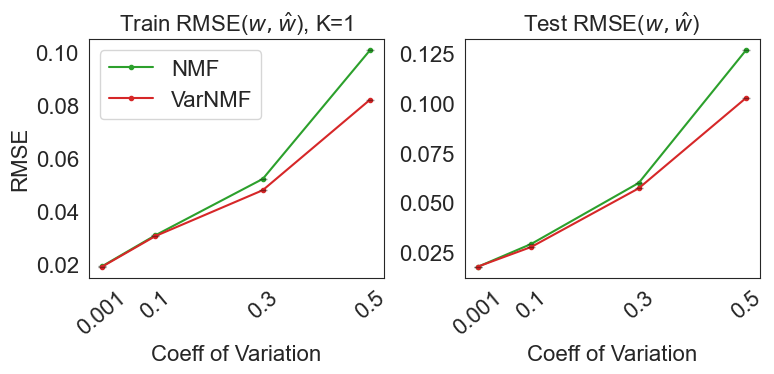

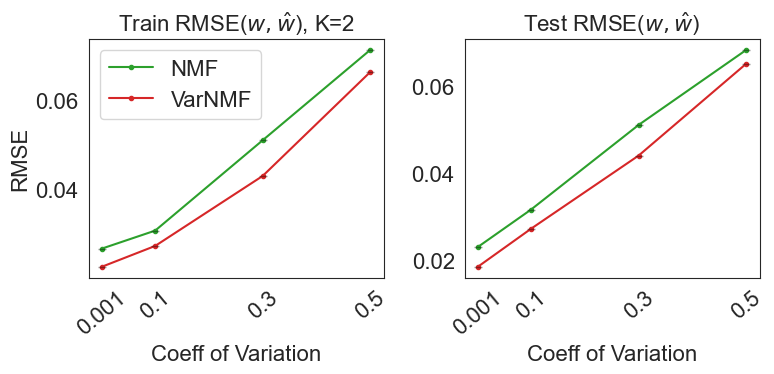

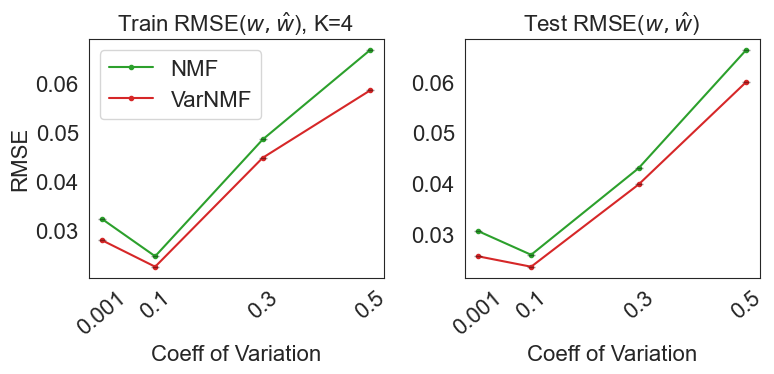

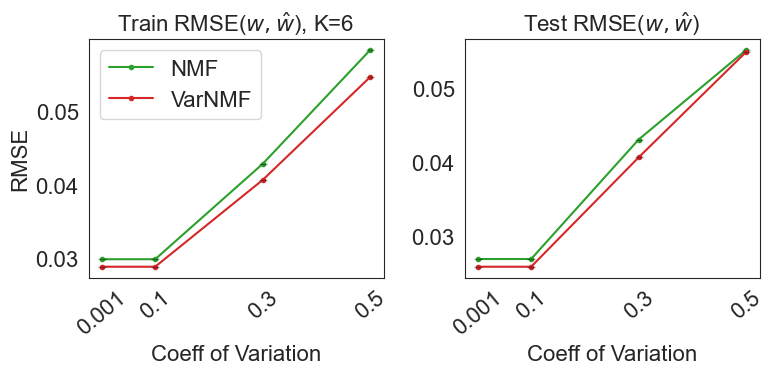

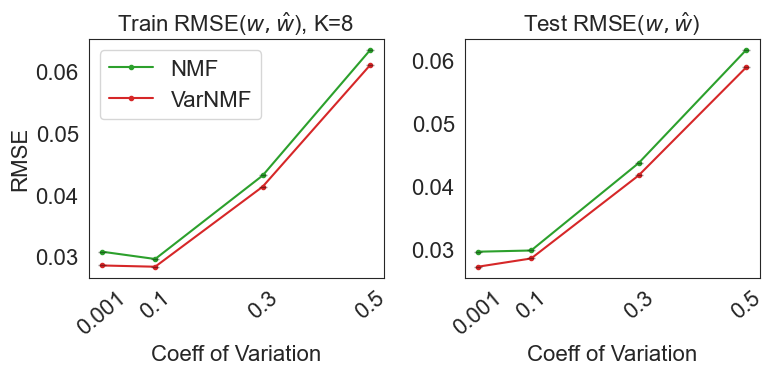

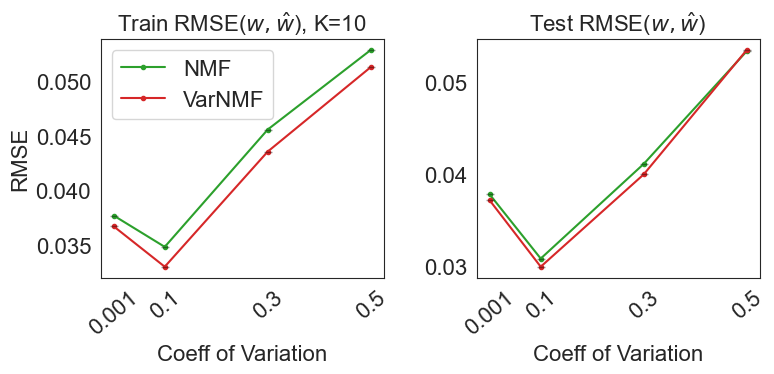

0.019164674
0.018996803


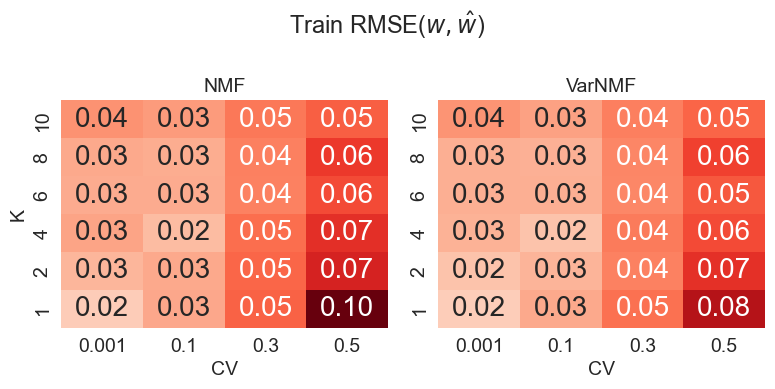

0.01764145
0.017734183


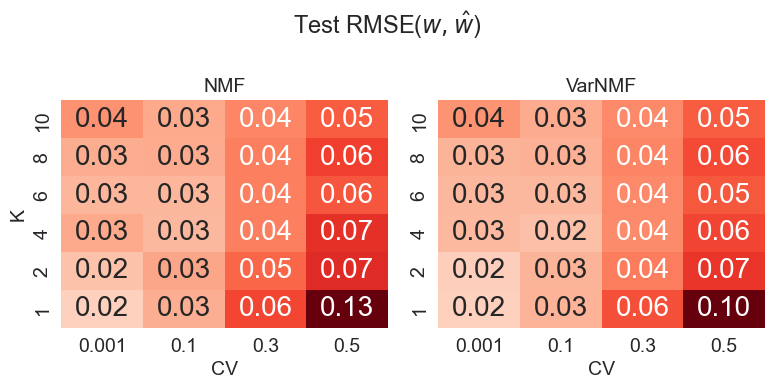

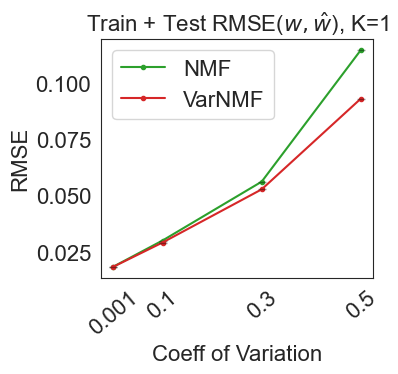

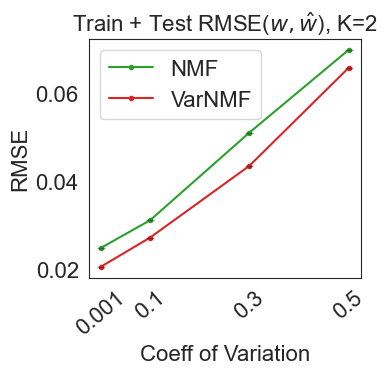

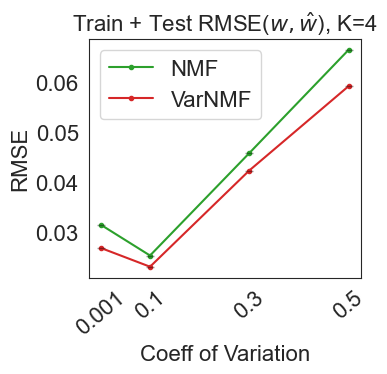

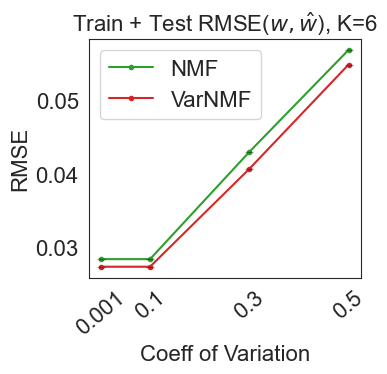

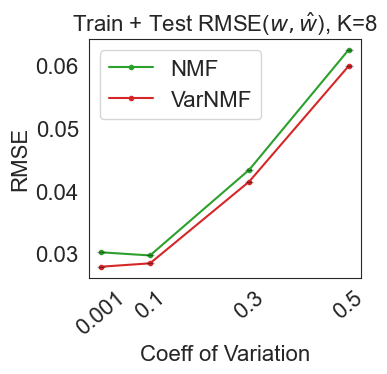

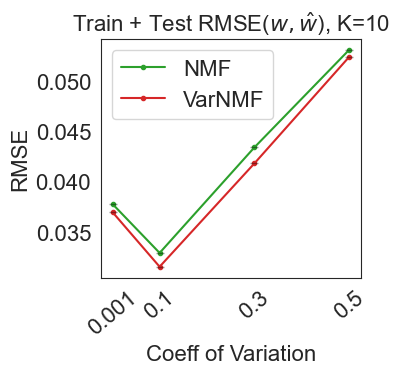

0.018418815
0.01837634


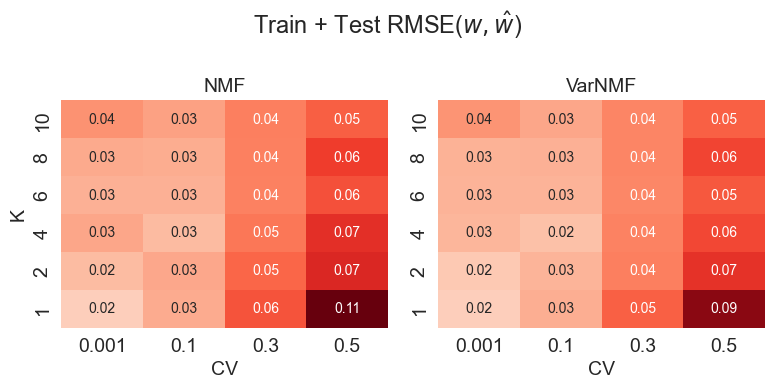

In [138]:
plot_score_fig(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=Ks,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='K')
plot_scores_table(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=Ks,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.1,
                  plots_path=plots_path, by='K')
plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=Ks,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='K')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ks,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.1,
                  plots_path=plots_path, by='K')

### by m_lam

In [139]:
train_all_scores = get_err_m_lams(['true'] +  rmse_targets, err_func, N, K, m_lams, train_test='train', T=T)
test_all_scores = get_err_m_lams(['true'] +  rmse_targets, err_func, N, K, m_lams, train_test='test', T=T)
concat_all_scores = get_err_m_lams(['true'] +  rmse_targets, err_func, N, K, m_lams, train_test='concat', T=T)

m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true
NMF
EM
m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test EM ll [-3.38190462]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true ll -3.494915785951912
test NMF ll [-3.52819702]
test EM ll [-3.49926718]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true ll -3.994740356666455
test NMF ll [-4.96785801]
test EM ll [-4.02158367]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
t

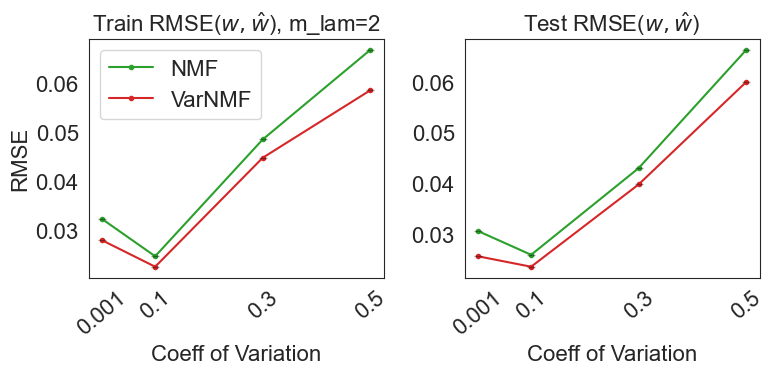

0.024738451
0.022606198


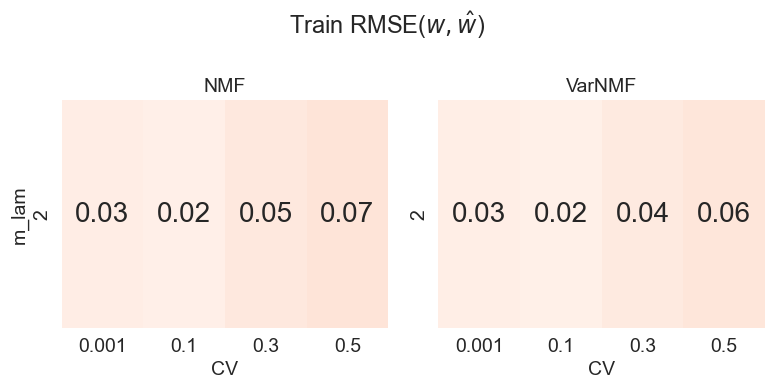

0.025941432
0.023594085


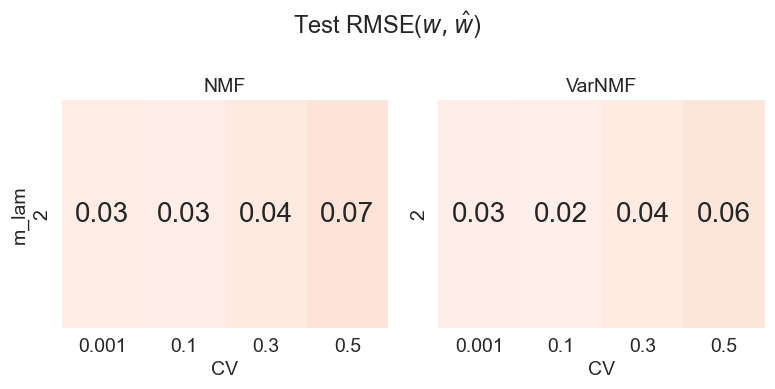

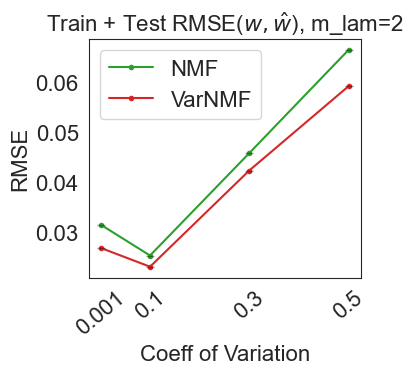

0.025347078
0.023105422


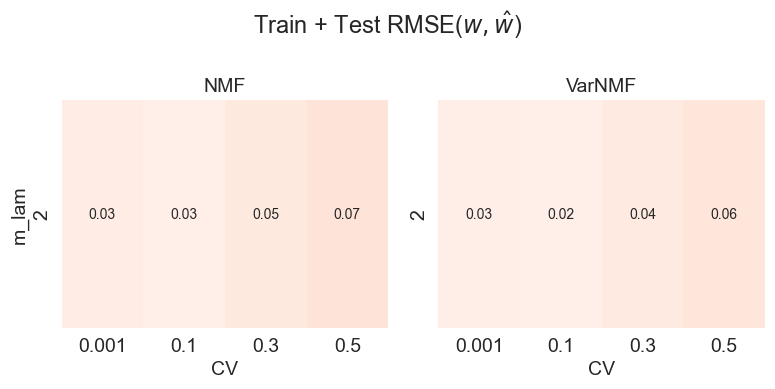

In [140]:
plot_score_fig(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=m_lams,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='m_lam')
plot_scores_table(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=m_lams,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.65,
                  plots_path=plots_path, by='m_lam')

plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=m_lams,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='m_lam')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=m_lams,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.65,
                  plots_path=plots_path, by='m_lam')

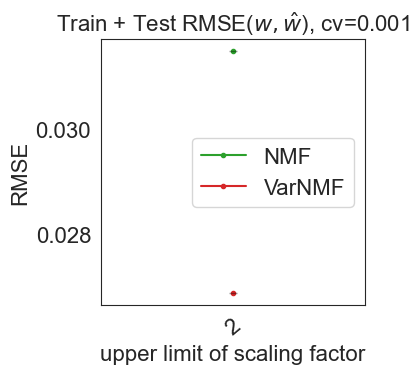

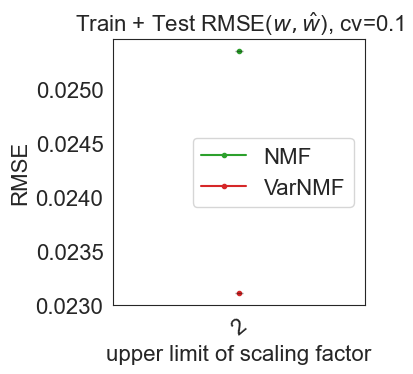

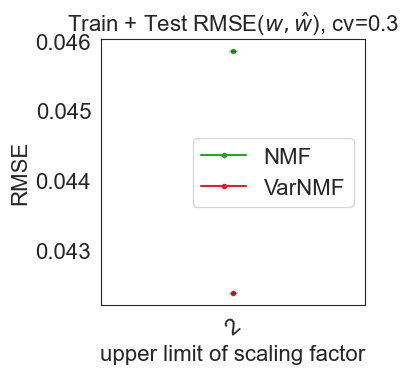

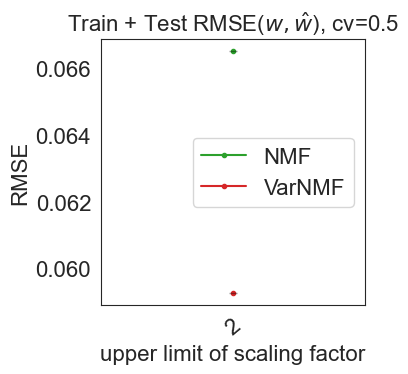

In [141]:
concat_all_scores_by_m_lams = {cv: {algo: pd.DataFrame({m_lam: concat_all_scores[m_lam][algo][cv] for m_lam in m_lams}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, m_lams, concat_all_scores_by_m_lams, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='upper limit of scaling factor')


### by N

In [142]:
train_all_scores = get_err_Ns(['true'] +  rmse_targets, err_func, Ns, K, m_lam, train_test='train', T=T)
test_all_scores = get_err_Ns(['true'] +  rmse_targets, err_func, Ns, K, m_lam, train_test='test', T=T)
concat_all_scores = get_err_Ns(['true'] +  rmse_targets, err_func, Ns, K, m_lam, train_test='concat', T=T)

N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true
NMF
EM
N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test EM ll [-3.38190462]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true ll -3.494915785951912
test NMF ll [-3.52819702]
test EM ll [-3.49926718]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true ll -3.994740356666455
test NMF ll [-4.96785801]
test EM ll [-4.02158367]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train

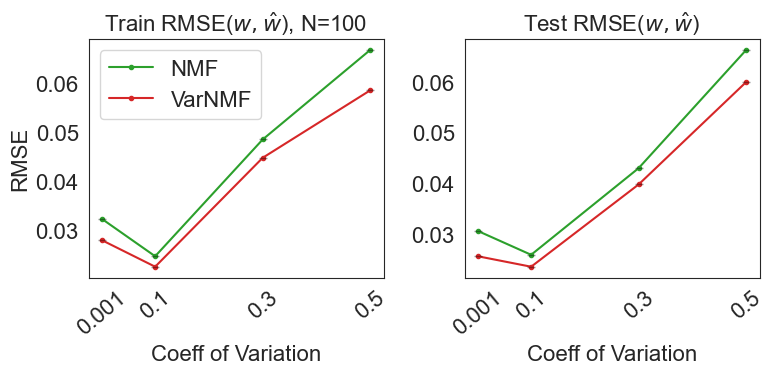

0.024738451
0.022606198


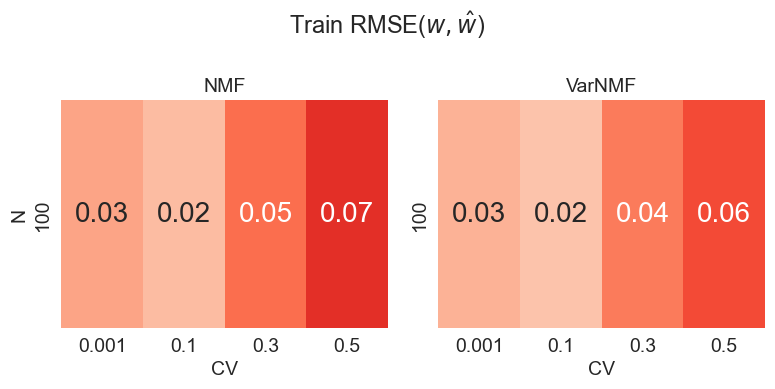

0.025941432
0.023594085


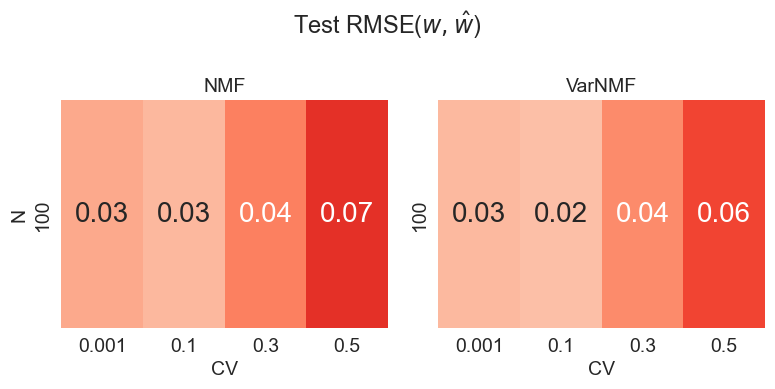

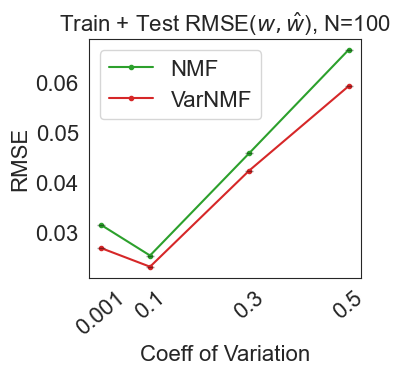

0.025347078
0.023105422


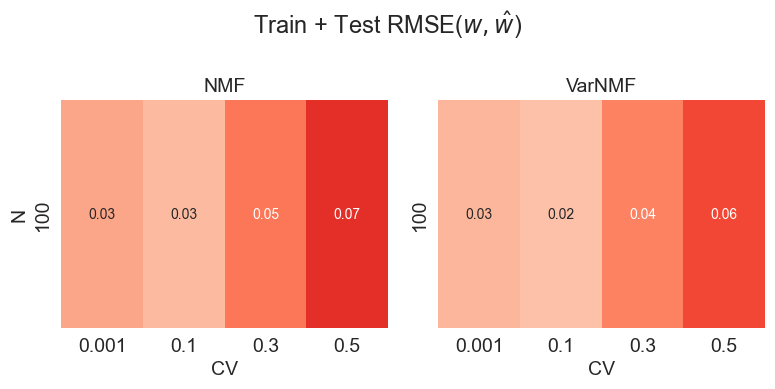

In [143]:
plot_score_fig(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=Ns,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='N')
plot_scores_table(rmse_targets, cvs, train_all_scores, test_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.1,
                  plots_path=plots_path, by='N')

plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=Ns,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='N')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=0.1,
                  plots_path=plots_path, by='N')

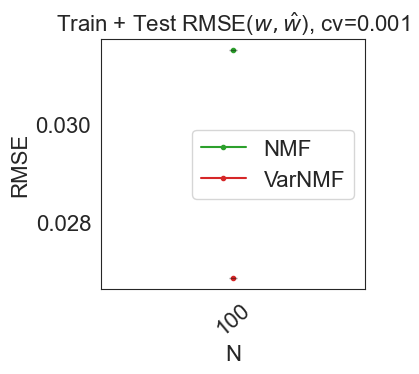

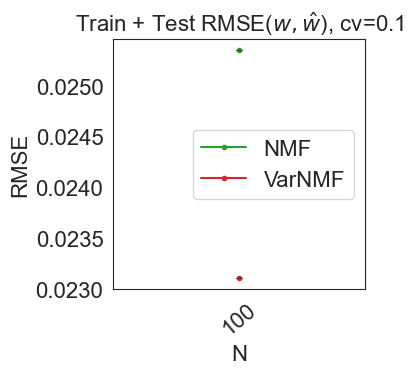

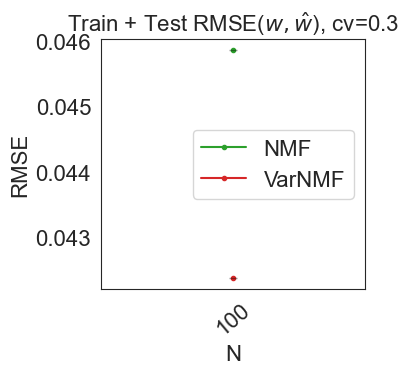

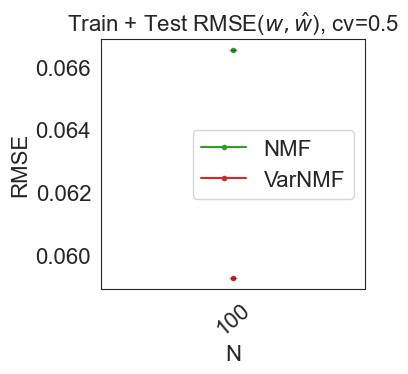

In [144]:
concat_all_scores_by_Ns = {cv: {algo: pd.DataFrame({N: concat_all_scores[N][algo][cv] for N in Ns}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, Ns, concat_all_scores_by_Ns, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='N')


## H

In [145]:
# H
err_label = r'RMSE($h,\hat{h}$)'
err_name = 'RMSE_H'
err_func = rmse_H

### by K

In [146]:
train_all_scores = get_err_Ks(['true'] +  rmse_targets, err_func, N, Ks, m_lam, train_test='train', T=T)

K 1
CV 0.001
0
true ll -2.8085632730756145
train NMF ll [-2.79862841]
train EM ll [-2.79857673]
true
NMF
EM
CV 0.1
0
true ll -2.9698906182216853
train NMF ll [-3.0600904]
train EM ll [-2.95395247]
true
NMF
EM
CV 0.3
0
true ll -3.524058521194692
train NMF ll [-5.45929822]
train EM ll [-3.51247173]
true
NMF
EM
CV 0.5
0
true ll -3.9082920678651827
train NMF ll [-10.56513807]
train EM ll [-3.89468987]
true
NMF
EM
K 2
CV 0.001
0
true ll -3.3391768632138104
train NMF ll [-3.31549436]
train EM ll [-3.31861553]
true
NMF
EM
CV 0.1
0
true ll -3.4309775759798855
train NMF ll [-3.47384146]
train EM ll [-3.40172491]
true
NMF
EM
CV 0.3
0
true ll -3.90731897639328
train NMF ll [-5.43303756]
train EM ll [-3.87906174]
true
NMF
EM
CV 0.5
0
true ll -4.224342396299727
train NMF ll [-8.35238594]
train EM ll [-4.19482195]
true
NMF
EM
K 4
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train

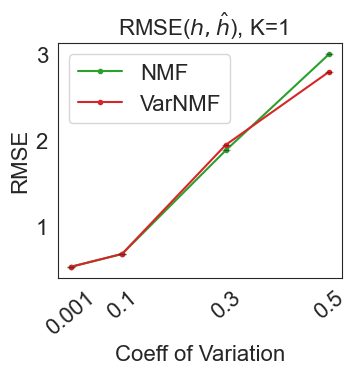

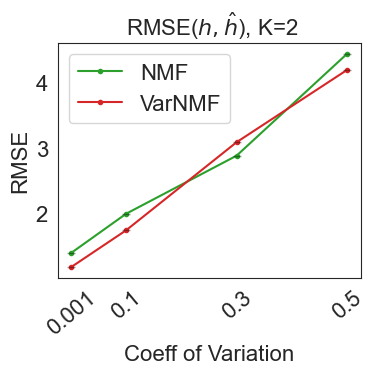

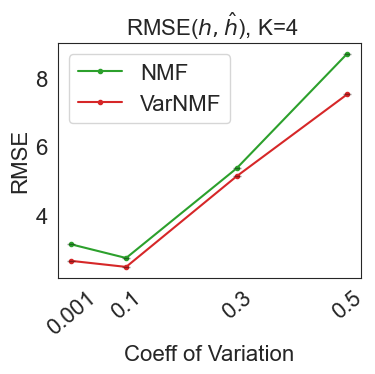

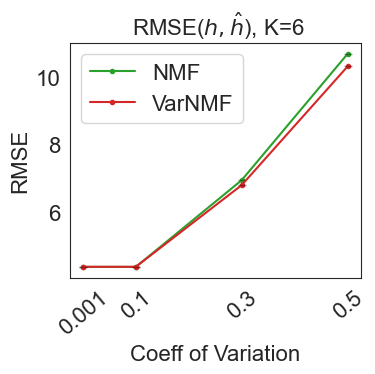

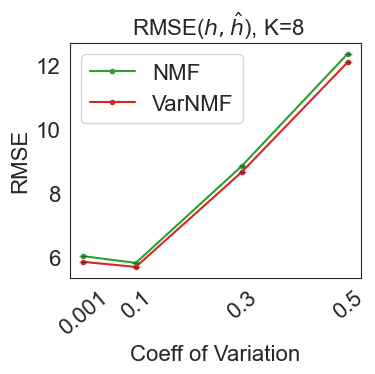

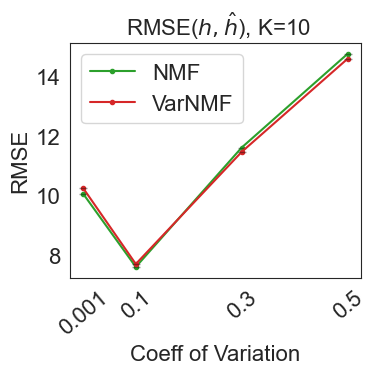

0.5234011
0.5247005


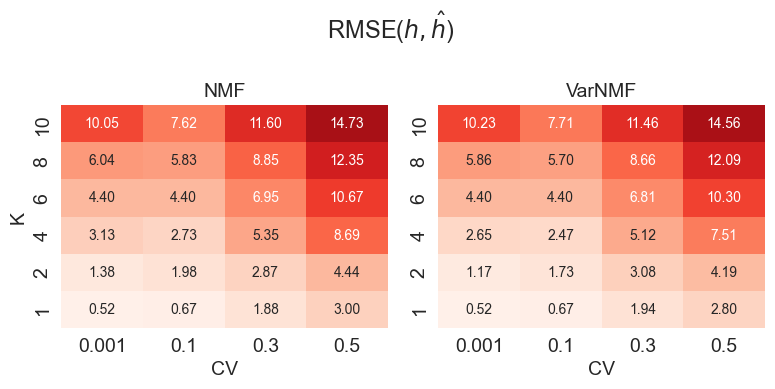

In [147]:
plot_single_score_fig(rmse_targets, cvs, train_all_scores, for_params=Ks,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='K', plot_title='')
plot_single_scores_table(rmse_targets, cvs, train_all_scores, for_params=Ks,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=17,
                  plots_path=plots_path, by='K', plot_title='')

### by m_lam

In [148]:
train_all_scores = get_err_m_lams(['true'] + rmse_targets, err_func, N, K, m_lams, train_test='train', T=T)

m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true
NMF
EM


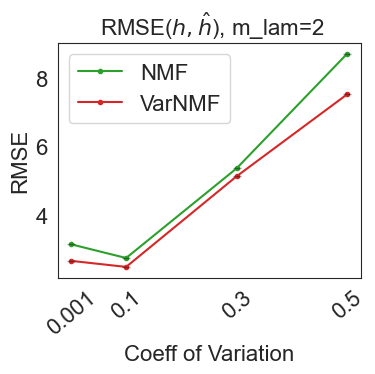

2.7301033
2.4702926


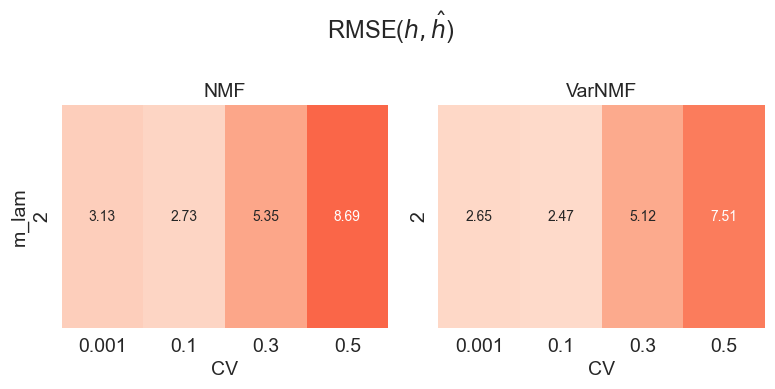

In [149]:
plot_single_score_fig(rmse_targets, cvs, train_all_scores, for_params=m_lams,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='m_lam', plot_title='')
plot_single_scores_table(rmse_targets, cvs, train_all_scores, for_params=m_lams,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=17,
                  plots_path=plots_path, by='m_lam', plot_title='')

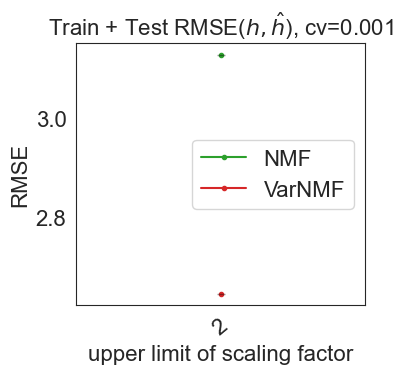

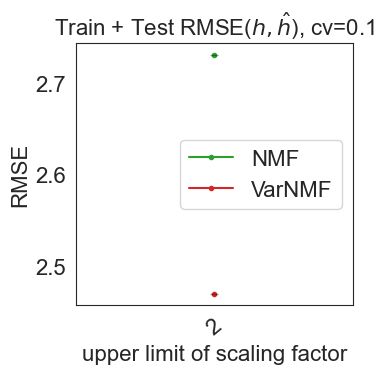

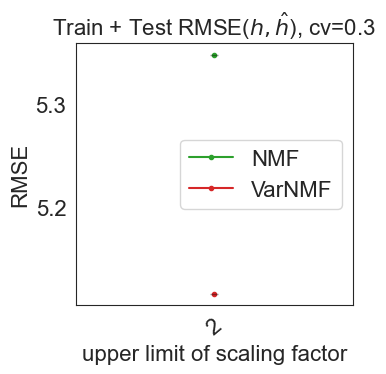

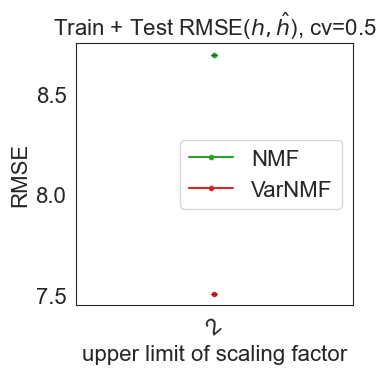

In [150]:
train_all_scores_by_m_lams = {cv: {algo: pd.DataFrame({m_lam: train_all_scores[m_lam][algo][cv] for m_lam in m_lams}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, m_lams, train_all_scores_by_m_lams, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='upper limit of scaling factor')


### by N

In [151]:
train_all_scores = get_err_Ns(['true'] + rmse_targets, err_func, Ns, K, m_lam, train_test='train', T=T)

N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true
NMF
EM


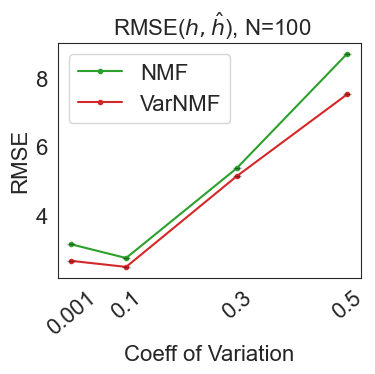

2.7301033
2.4702926


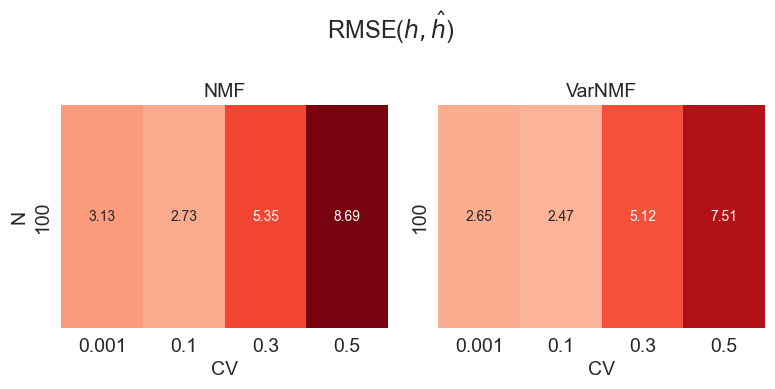

2.7301033
2.4702926


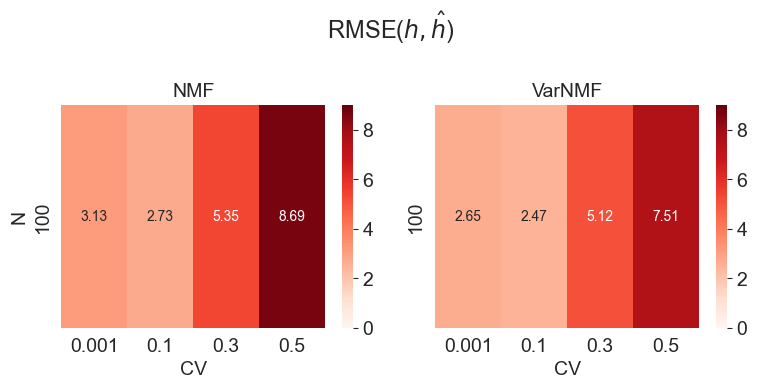

In [152]:

plot_single_score_fig(rmse_targets, cvs, train_all_scores, for_params=Ns,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='N', plot_title='')
plot_single_scores_table(rmse_targets, cvs, train_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=9,
                  plots_path=plots_path, by='N', plot_title='')
plot_single_scores_table(rmse_targets, cvs, train_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=9,
                  plots_path=plots_path, by='N', plot_title='', cbar=True)

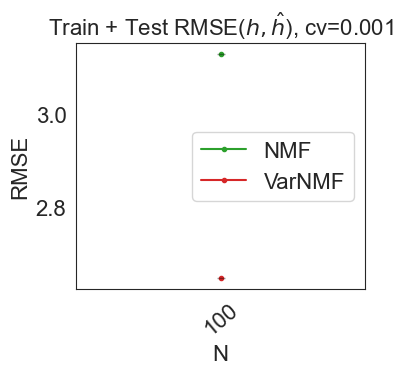

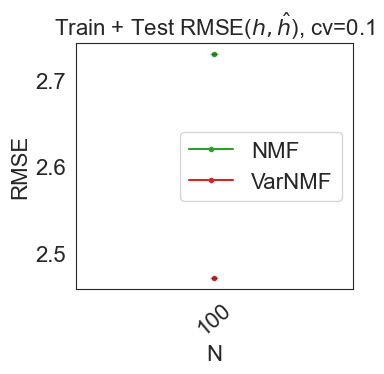

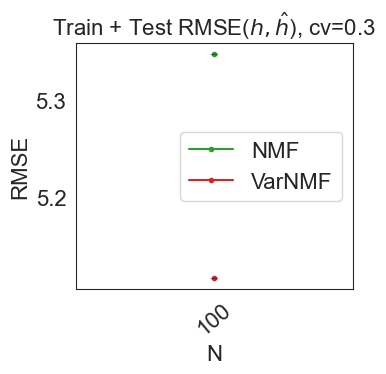

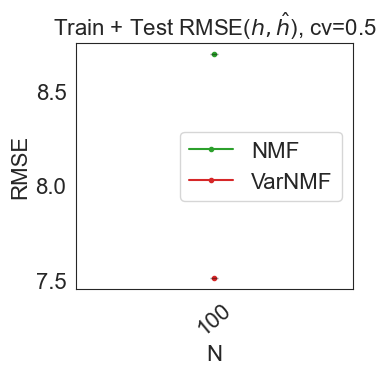

In [153]:

train_all_scores_by_Ns = {cv: {algo: pd.DataFrame({N: train_all_scores[N][algo][cv] for N in Ns}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, Ns, train_all_scores_by_Ns, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='N')


## H[i]

In [154]:
# H
err_label = r'RMSE($h[i],\hat{h[i]}$)'
err_name = 'RMSE_H_post2'
err_func = rmse_posteriorH2

### by K

In [155]:
concat_all_scores = get_err_Ks(['true'] +  rmse_targets, err_func, N, Ks, m_lam, train_test='concat', T=T)

K 1
CV 0.001
0
true ll -2.8085632730756145
train NMF ll [-2.79862841]
train EM ll [-2.79857673]
true ll -2.8249589834347675
test NMF ll [-2.82782369]
test EM ll [-2.83115228]
true
NMF
EM
CV 0.1
0
true ll -2.9698906182216853
train NMF ll [-3.0600904]
train EM ll [-2.95395247]
true ll -2.9559952690173588
test NMF ll [-3.06061712]
test EM ll [-2.96083629]
true
NMF
EM
CV 0.3
0
true ll -3.524058521194692
train NMF ll [-5.45929822]
train EM ll [-3.51247173]
true ll -3.5646574529711854
test NMF ll [-5.67142952]
test EM ll [-3.56728716]
true
NMF
EM
CV 0.5
0
true ll -3.9082920678651827
train NMF ll [-10.56513807]
train EM ll [-3.89468987]
true ll -3.923717257013776
test NMF ll [-11.32442275]
test EM ll [-3.92965047]
true
NMF
EM
K 2
CV 0.001
0
true ll -3.3391768632138104
train NMF ll [-3.31549436]
train EM ll [-3.31861553]
true ll -3.2874523108952127
test NMF ll [-3.29226332]
test EM ll [-3.29427838]
true
NMF
EM
CV 0.1
0
true ll -3.4309775759798855
train NMF ll [-3.47384146]
train EM ll [-3.4017

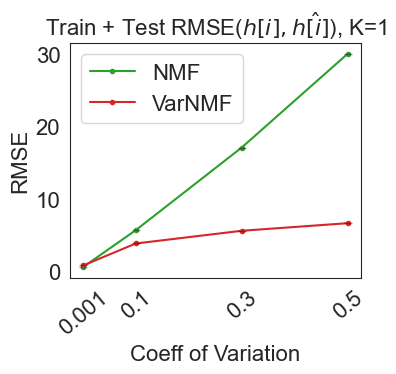

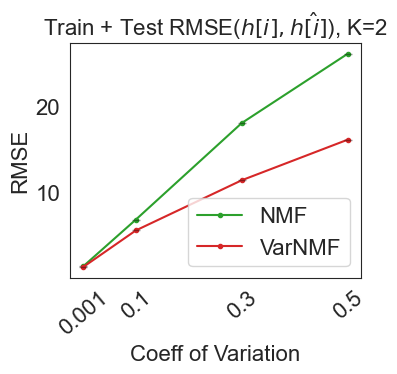

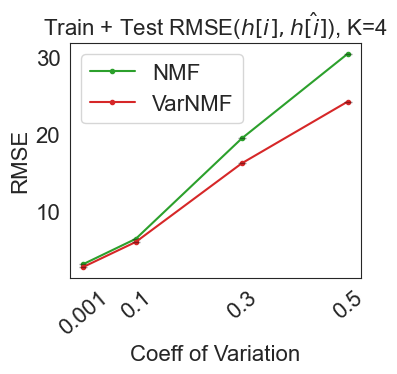

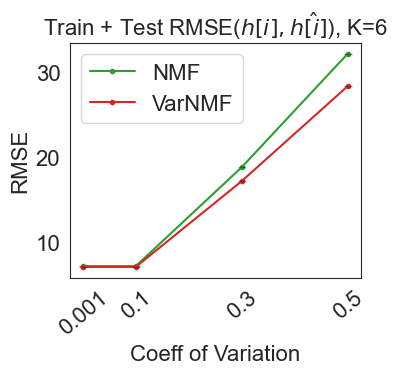

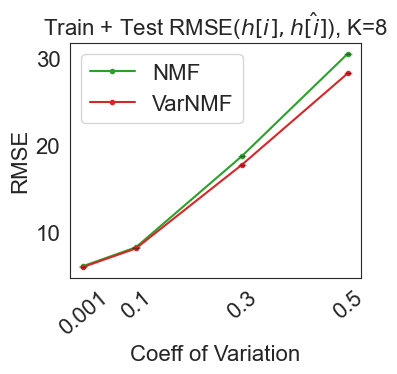

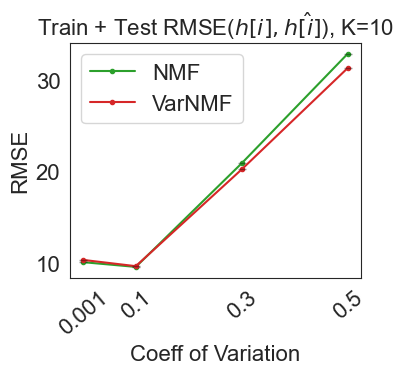

0.52650046
0.73920554


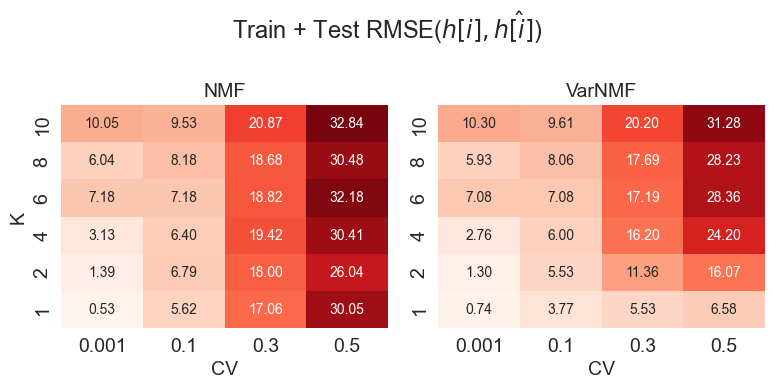

0.52650046
0.73920554


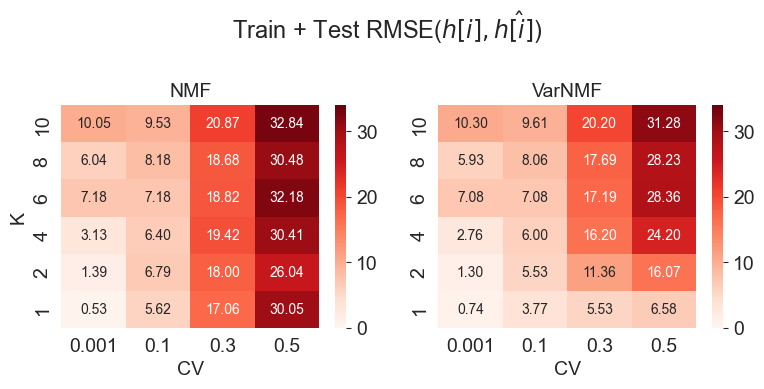

In [156]:
plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=Ks,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='K')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ks,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='K')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ks,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='K', cbar=True)

In [157]:
concat_all_scores = get_err_m_lams(['true'] +  rmse_targets, err_func, N, K, m_lams, train_test='concat', T=T)

m_lam 2
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test EM ll [-3.38190462]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true ll -3.494915785951912
test NMF ll [-3.52819702]
test EM ll [-3.49926718]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true ll -3.994740356666455
test NMF ll [-4.96785801]
test EM ll [-4.02158367]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true ll -4.3993287448585034
test NMF ll [-7.60660492]
test EM ll [-4.42045543]
true
NMF
EM


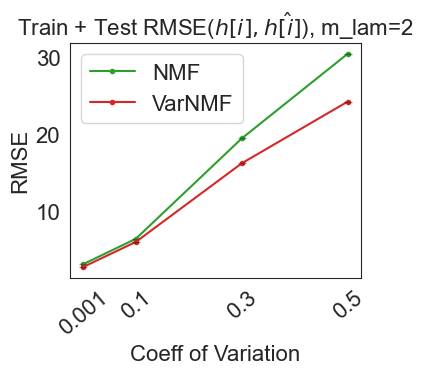

3.1280334
2.7608302


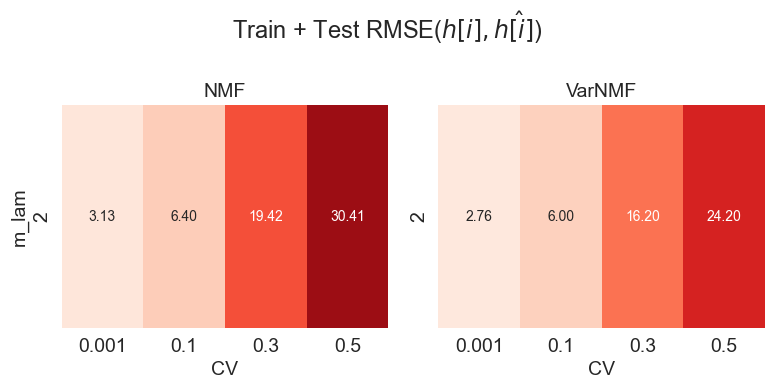

3.1280334
2.7608302


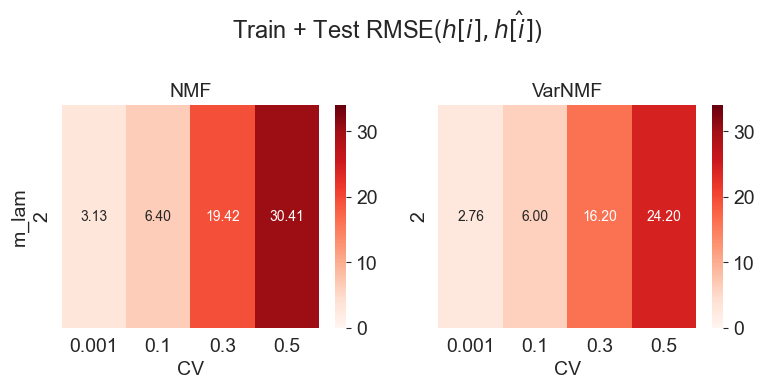

In [158]:
plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=m_lams,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='m_lam')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=m_lams,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='m_lam')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=m_lams,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='m_lam', cbar=True)

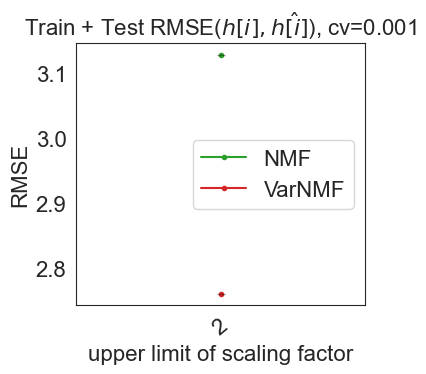

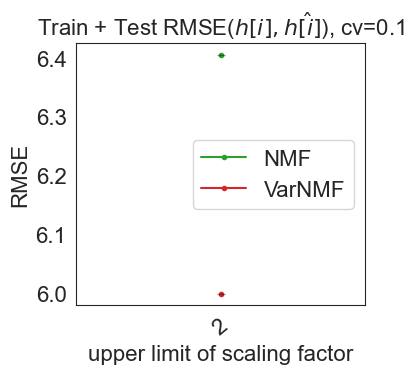

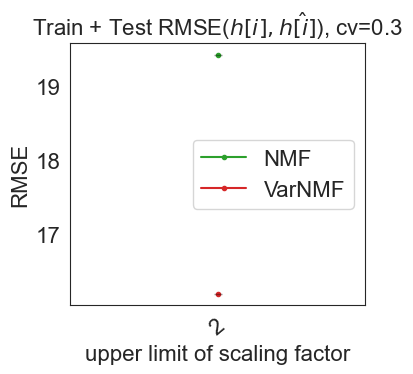

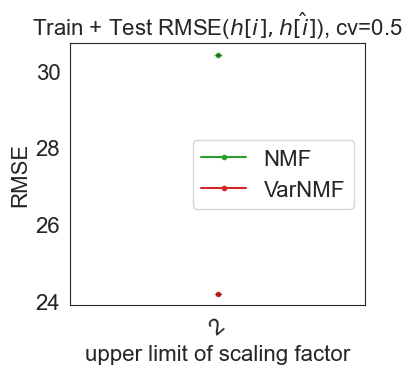

In [159]:
concat_all_scores_by_m_lams = {cv: {algo: pd.DataFrame({m_lam: concat_all_scores[m_lam][algo][cv] for m_lam in m_lams}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, m_lams, concat_all_scores_by_m_lams, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='upper limit of scaling factor')


In [160]:
concat_all_scores = get_err_Ns(['true'] +  rmse_targets, err_func, Ns, K, m_lam, train_test='concat', T=T)

N 100
CV 0.001
0
true ll -3.3679922595381737
train NMF ll [-3.32846287]
train EM ll [-3.33666063]
true ll -3.3709570090681313
test NMF ll [-3.3793886]
test EM ll [-3.38190462]
true
NMF
EM
CV 0.1
0
true ll -3.498488142774999
train NMF ll [-3.48503792]
train EM ll [-3.45414572]
true ll -3.494915785951912
test NMF ll [-3.52819702]
test EM ll [-3.49926718]
true
NMF
EM
CV 0.3
0
true ll -4.064452422416257
train NMF ll [-4.88848636]
train EM ll [-4.00690143]
true ll -3.994740356666455
test NMF ll [-4.96785801]
test EM ll [-4.02158367]
true
NMF
EM
CV 0.5
0
true ll -4.394688178382814
train NMF ll [-7.26980221]
train EM ll [-4.33775479]
true ll -4.3993287448585034
test NMF ll [-7.60660492]
test EM ll [-4.42045543]
true
NMF
EM


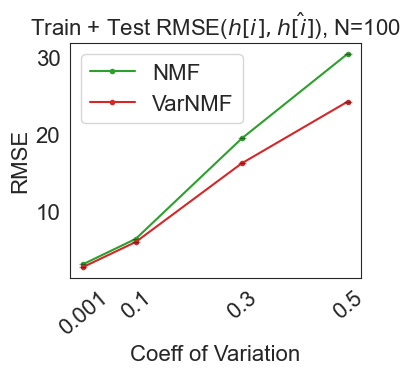

3.1280334
2.7608302


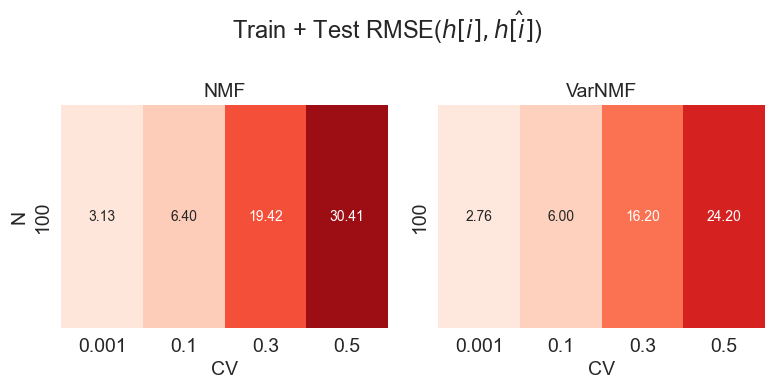

3.1280334
2.7608302


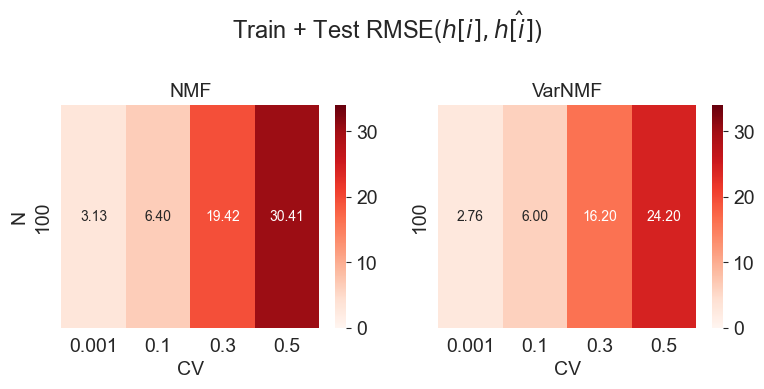

In [161]:
plot_single_score_fig(rmse_targets, cvs, concat_all_scores, for_params=Ns,
                      err_label=err_label, err_name=err_name, ylabel='RMSE',
                      plots_path=plots_path, by='N')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='N')
plot_single_scores_table(rmse_targets, cvs, concat_all_scores, for_params=Ns,
                  err_name=err_name, err_label=err_label, vmin=0, vmax=34,
                  plots_path=plots_path, by='N', cbar=True)

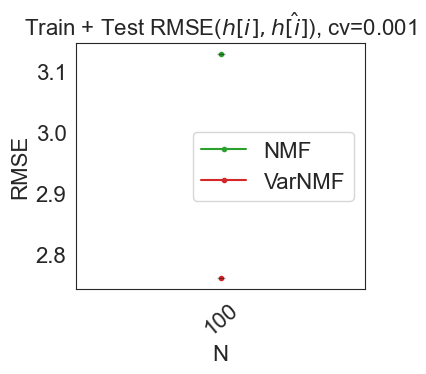

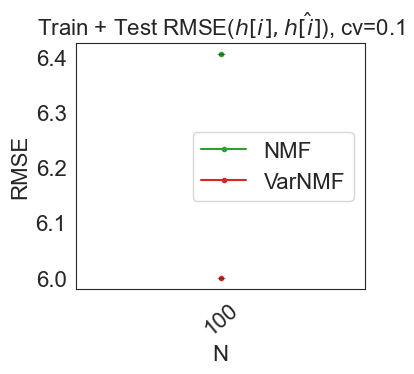

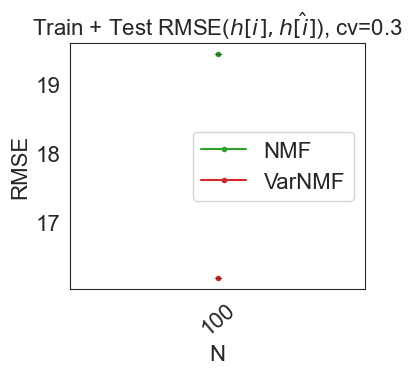

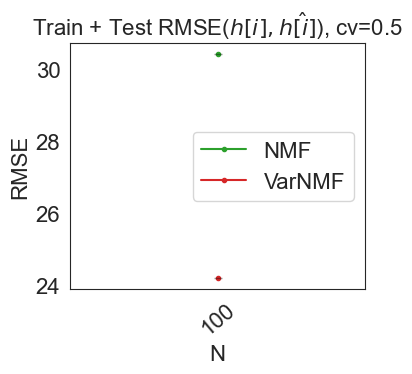

In [162]:
concat_all_scores_by_Ns = {cv: {algo: pd.DataFrame({N: concat_all_scores[N][algo][cv] for N in Ns}) for algo in rmse_targets} for cv in cvs}
plot_single_score_fig(rmse_targets, Ns, concat_all_scores_by_Ns, for_params=cvs,
               err_label=err_label, err_name=err_name, ylabel='RMSE',
               plots_path=plots_path, by='cv', xlabel='N')
